# Benchmark Analysis - H7

In [275]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [276]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [277]:
matplotlib.style.use('seaborn-v0_8')  

In [278]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [279]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [280]:
GCC_TBB_COLOR           = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'
GCC_TBB_COLOR_TERTIARY  = 'tomato'

NVC_OMP_COLOR           = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'
NVC_OMP_COLOR_TERTIARY  = 'aquamarine'

NVC_GPU_COLOR = 'beige'

In [281]:
plot_save_dir = './plots/h7'

## Utils 

In [282]:
def get_path(*entries):
    return os.path.join(*entries)

In [283]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [284]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [285]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [286]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO", include_bytes=False) -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP,include_bytes_per_second=include_bytes)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [287]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [288]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [289]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [290]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [291]:
def get_strong_scaling_algo(compiler_location:str,
                            compiler_name:str,
                            bench_name:str,
                            base_of:Optional[str] = None) -> pd.DataFrame:
    
    seq_base = None

    if base_of:
        # base it of a other file and not the own sec
        seq_base = get_seq_base(base_of)
    else:
        ## seq base
        seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

In [292]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str,exec_suffix:str='par') -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}_{exec_suffix}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

In [541]:
def justify(a, invalid_val=0, axis=1, side='left'):    
    """
    Justifies a 2D array

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """

    if invalid_val is np.nan:
        #change to notnull
        mask = pd.notnull(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    #change dtype to object
    out = np.full(a.shape, invalid_val, dtype=object)  
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

# H7
> Employing specific parallel algorithms tends to yield superior performance/strong scaling compared to utilizing custom
> implementations that rely on various other parallel algorithm functions.


## `b7_1` copy logic

In [440]:
benchmark_names = [
    ("b7_1_copy",'std::copy'),
    ("b7_1_custom_copy_with_foreach",'std::foreach')
]

strong_scale_base = 'b7_1_copy'


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - copy logic

Check how the runtime without constraining the threads develops with increasing input size

In [441]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_time_merged = data[0]

for i in range(1,len(data)):
    b7_1_time_merged = pd.merge(b7_1_time_merged,data[i], on='n')

b7_1_time_merged

,GCC(TBB) - std::copy,n,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,5595.56,4,5978.93,10608.7,10073.10
1,10827.20,8,12120.80,10623.3,10231.50
2,21857.90,16,17361.50,10665.2,11357.70
3,26537.90,32,22442.10,11166.3,12054.80
4,27288.20,64,25338.60,12815.2,12573.20
5,32403.40,128,26805.90,12311.3,11651.20
6,33860.70,256,30244.70,11860.6,11682.10
7,36206.70,512,35350.70,11378.6,11410.90
8,39381.50,1024,38884.70,11164.1,9918.84
9,44346.20,2048,42822.10,11393.2,11876.70


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [442]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_1_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_1_strong_scaling_merged = pd.merge(b7_1_strong_scaling_merged,data[i], on='threads')


b7_1_strong_scaling_merged

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.699920,0.283722,0.077386,0.037897
1,2,0.909785,0.493201,0.154135,0.079399
2,4,1.972461,0.956322,0.307790,0.163052
3,8,2.146555,1.329385,0.615286,0.323622
4,16,2.730660,1.896029,1.229926,0.628180
5,32,3.056203,2.210050,2.429264,1.290441
6,64,2.983533,2.197806,4.710531,2.534781


In [443]:
## efficiency graph

b7_1_efficiency = b7_1_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_1_efficiency[f'{compiler_name} - {display_name}'] = b7_1_efficiency[f'{compiler_name} - {display_name}'] / b7_1_efficiency['threads']

b7_1_efficiency

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.699920,0.283722,0.077386,0.037897
1,2,0.454893,0.246600,0.077067,0.039700
2,4,0.493115,0.239081,0.076948,0.040763
3,8,0.268319,0.166173,0.076911,0.040453
4,16,0.170666,0.118502,0.076870,0.039261
5,32,0.095506,0.069064,0.075915,0.040326
6,64,0.046618,0.034341,0.073602,0.039606


### Mbytes/s

In [444]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_1_bytes_merged = pd.merge(b7_1_bytes_merged,data[i], on='n')

b7_1_bytes_merged

,n,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,4,5.71882,5.35213,3.01640,3.17678
1,8,5.91103,5.28020,6.02451,6.25520
2,16,5.85601,7.37265,12.00160,11.26990
3,32,9.64658,11.40710,22.92620,21.23630
4,64,18.76270,20.20630,39.95270,40.72170
5,128,31.60160,38.20060,83.17540,87.88760
6,256,60.48310,67.71430,172.67300,175.31000
7,512,113.12800,115.86800,359.97500,358.95600
8,1024,208.01700,210.67400,733.77900,825.90300
9,2048,369.45700,382.60700,1438.05000,1379.50000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/3501768566.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


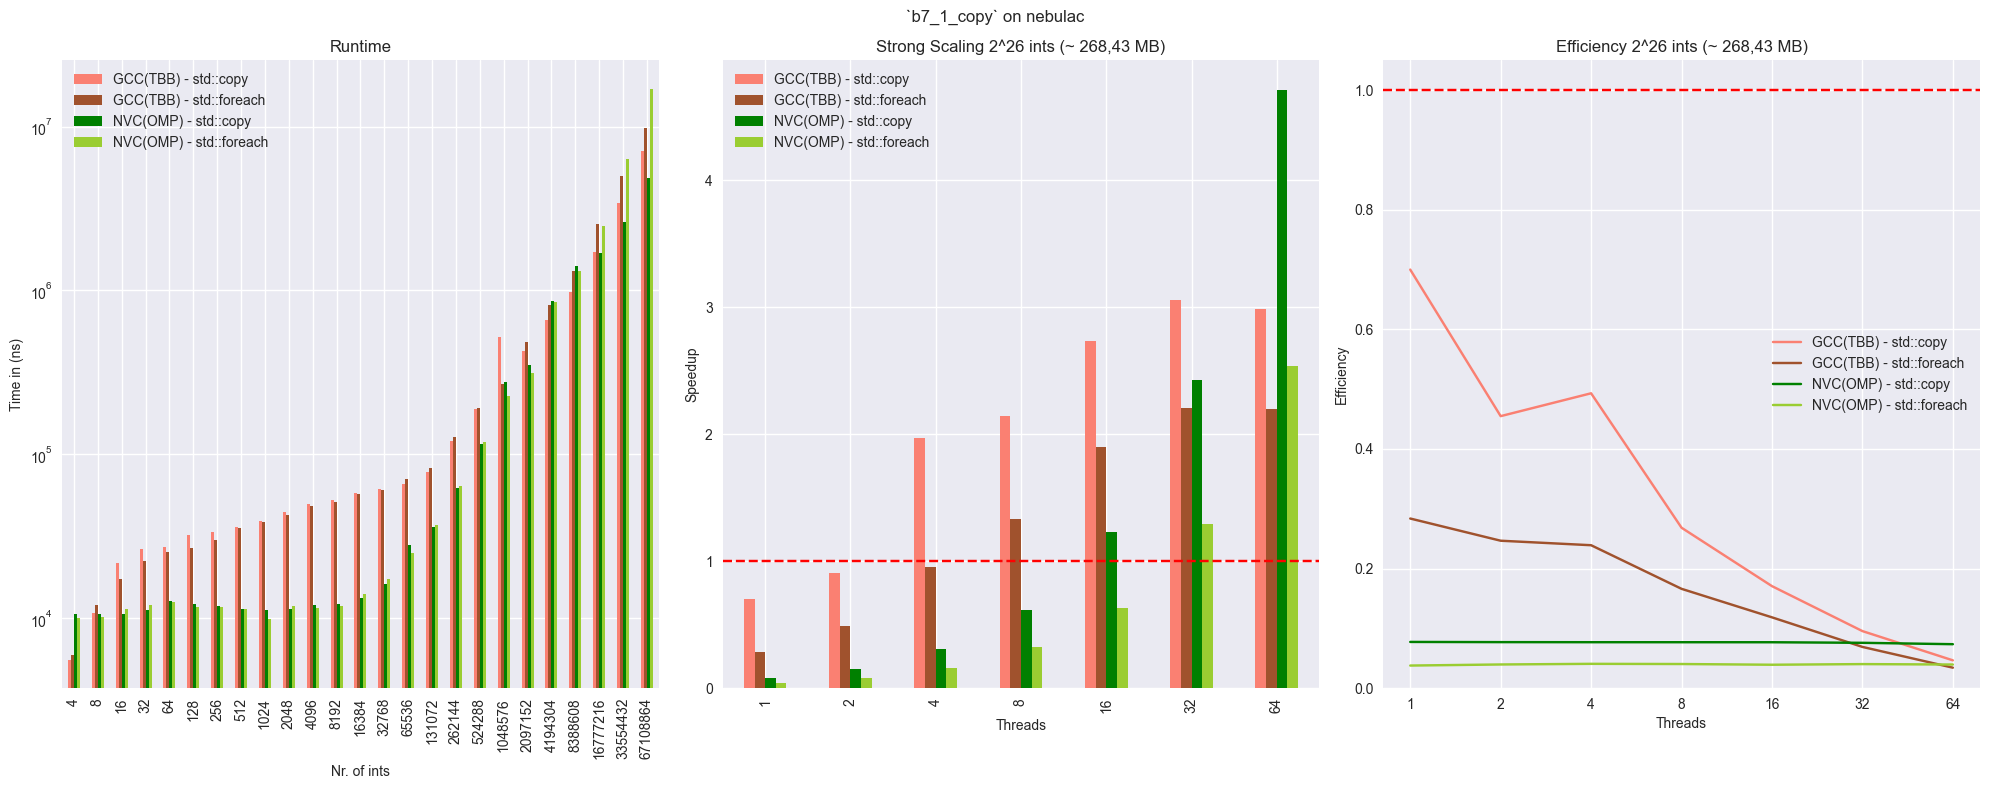

In [445]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_1_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_1_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,2.75)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b7_1_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_1_copy` on {device_name}")

fig.tight_layout()

plot(f"`b7_1_copy` {device_name}")

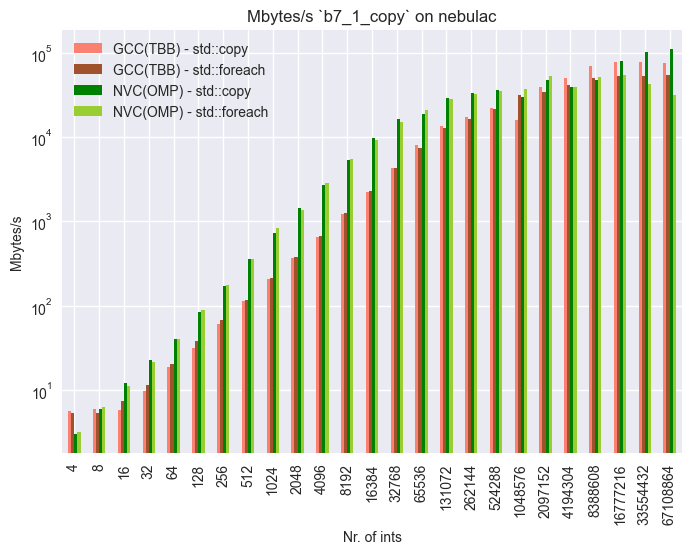

In [299]:
# mybtes graph


b7_1_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                    )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_1_copy` on {device_name}')


plot(f'`b7_1_copy` Mbytes_s on {device_name}')

## `b7_2` -  all_true

In [300]:
benchmark_names = [
    ("b7_2_all_of_all_true",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_all_true",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_all_true'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_true

Check how the runtime without constraining the threads develops with increasing input size

In [301]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_time_merged = pd.merge(b7_2_time_merged,data[i], on='n')

b7_2_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5239.95,4,2537.82,46116.0,19714.5
1,10297.70,8,7593.97,46190.7,20333.4
2,15682.10,16,15075.90,43821.3,21376.4
3,23378.20,32,21258.70,45020.6,21641.1
4,27337.30,64,26968.40,46514.4,22923.5
5,33538.70,128,30392.40,58613.3,23265.6
6,34776.50,256,33524.40,59128.3,22629.2
7,36244.50,512,34680.50,47881.5,22320.6
8,38785.90,1024,36177.10,47308.8,22705.6
9,42217.20,2048,38422.10,47408.6,24707.9


### Strong Scaling - all true
 
2^26 fixed input size with threads 1-64

In [302]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_strong_scaling_merged = pd.merge(b7_2_strong_scaling_merged,data[i], on='threads')


b7_2_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.104811,0.745061,0.310435,0.418370
1,2,2.084388,1.512965,0.611838,0.831578
2,4,3.537259,2.856997,1.166645,1.650964
3,8,4.791163,4.800049,1.990392,3.278300
4,16,7.558507,7.311350,2.310528,6.488933
5,32,8.630577,8.588706,2.123893,12.709331
6,64,8.996256,9.305921,2.572011,17.615270


In [303]:
## efficiency graph

b7_2_efficiency = b7_2_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_efficiency[f'{compiler_name} - {display_name}'] = b7_2_efficiency[f'{compiler_name} - {display_name}'] / b7_2_efficiency['threads']

b7_2_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.104811,0.745061,0.310435,0.418370
1,2,1.042194,0.756483,0.305919,0.415789
2,4,0.884315,0.714249,0.291661,0.412741
3,8,0.598895,0.600006,0.248799,0.409787
4,16,0.472407,0.456959,0.144408,0.405558
5,32,0.269706,0.268397,0.066372,0.397167
6,64,0.140566,0.145405,0.040188,0.275239


### Mbytes/s

In [304]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_all_true_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_all_true_bytes_merged = pd.merge(b7_2_all_true_bytes_merged,data[i], on='n')

b7_2_all_true_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.05347,12.60930,0.346951,1.62317
1,8,3.10750,8.42774,0.692780,3.14754
2,16,4.08110,8.49039,1.460480,5.98792
3,32,5.47518,12.04210,2.843150,11.82940
4,64,9.36450,18.98520,5.503670,22.33520
5,128,15.26590,33.69260,8.735220,44.01350
6,256,29.44520,61.08990,17.318300,90.50250
7,512,56.50510,118.10700,42.772300,183.50800
8,1024,105.60500,226.44200,86.580200,360.79200
9,2048,194.04400,426.42100,172.796000,663.10700


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/1266373404.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


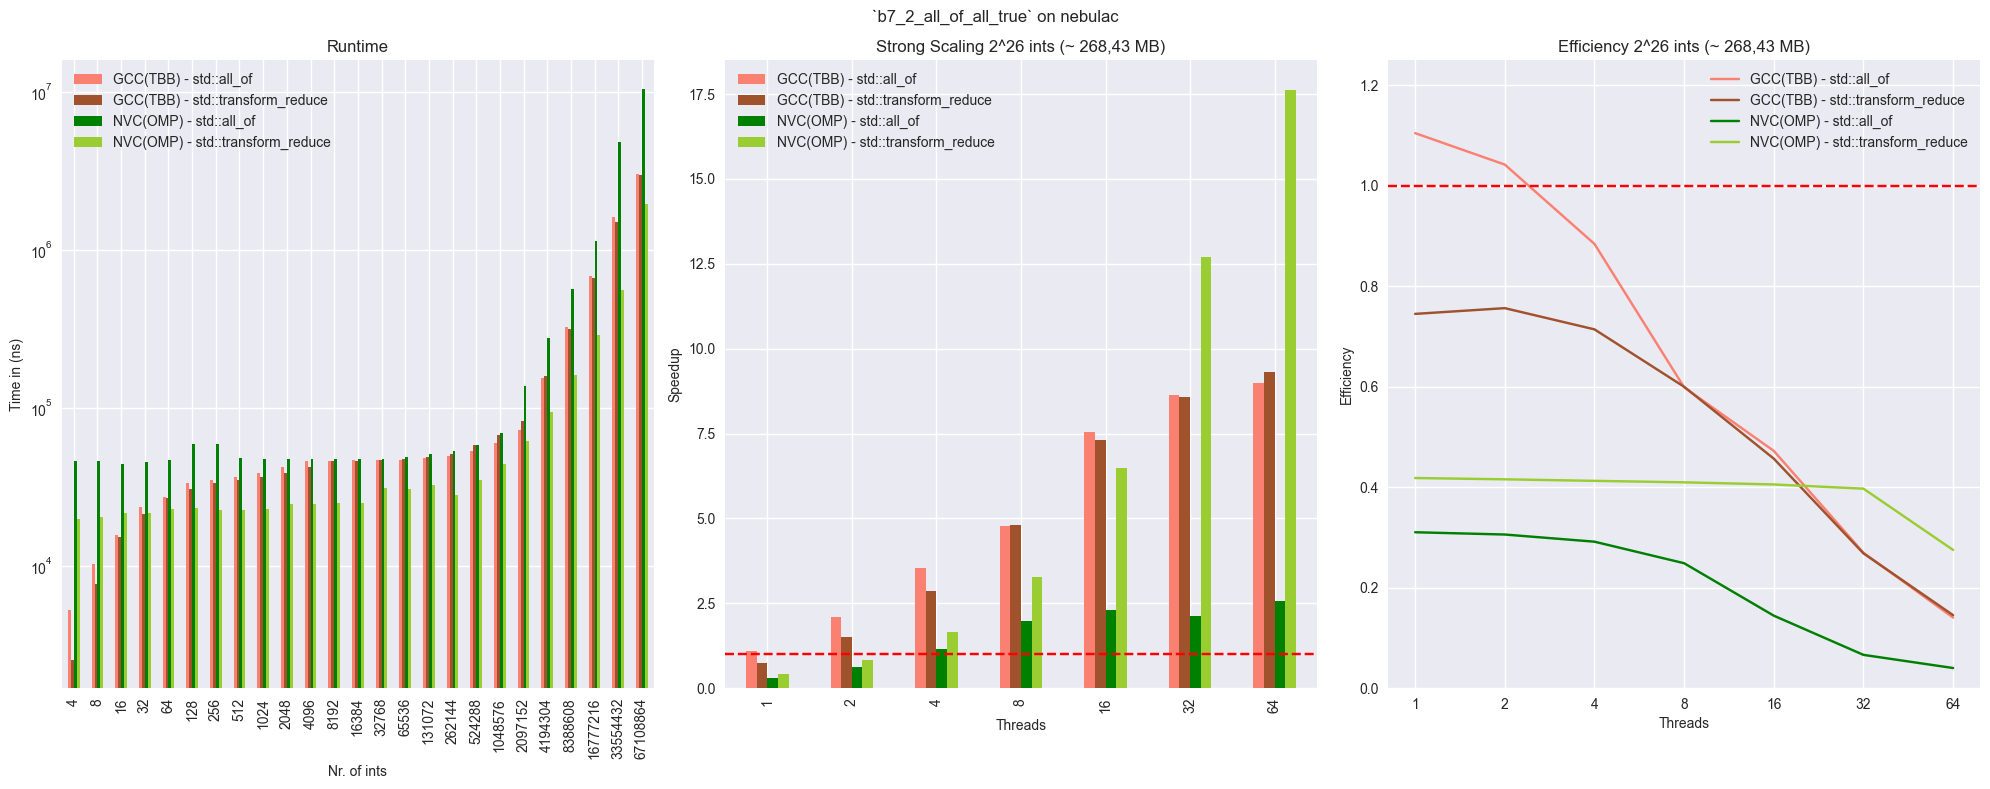

In [305]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_all_true` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_all_true` {device_name}")

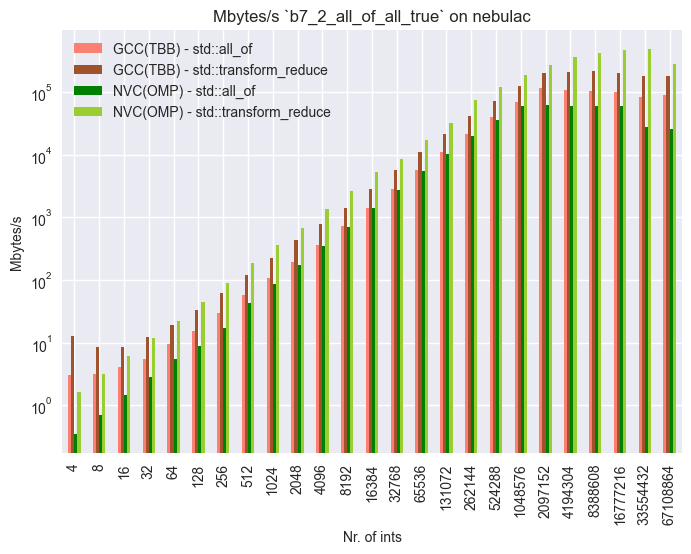

In [306]:
# mybtes graph


b7_2_all_true_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_all_true` on {device_name}')


plot(f'`b7_2_all_of_all_true` Mbytes_s on {device_name}')

## `b7_2` -  first_false

In [307]:
benchmark_names = [
    ("b7_2_all_of_first_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_first_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_first_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - first_false

Check how the runtime without constraining the threads develops with increasing input size

In [308]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_first_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_time_merged = pd.merge(b7_2_first_false_time_merged,data[i], on='n')

b7_2_first_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5017.56,4,2238.68,41668.5,23246.4
1,12326.80,8,8598.30,41961.5,23350.1
2,16286.90,16,14736.00,42052.5,23360.9
3,19790.00,32,21016.20,42617.7,24448.6
4,18619.30,64,25972.50,43408.9,25944.2
5,21000.20,128,29612.40,43411.0,27418.7
6,23542.90,256,31796.00,42786.3,24677.9
7,23580.30,512,32268.30,43060.8,29357.9
8,28299.60,1024,34266.30,43479.8,29414.8
9,23328.50,2048,37074.10,43311.7,27224.2


### Strong Scaling - first_false
 
2^26 fixed input size with threads 1-64

In [309]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_first_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_strong_scaling_merged = pd.merge(b7_2_first_false_strong_scaling_merged,data[i], on='threads')


b7_2_first_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.046215,0.000001,0.000028,7.073857e-07
1,2,0.008808,0.000003,0.000055,1.405232e-06
2,4,0.003189,0.000005,0.000107,2.772884e-06
3,8,0.002786,0.000008,0.000190,5.381700e-06
4,16,0.002376,0.000013,0.000315,1.001560e-05
5,32,0.002356,0.000015,0.000490,1.804904e-05
6,64,0.001979,0.000016,0.000636,2.969857e-05


In [310]:
## efficiency graph

b7_2_first_false_efficiency = b7_2_first_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_first_false_efficiency['threads']

b7_2_first_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.046215,1.237885e-06,0.000028,7.073857e-07
1,2,0.004404,1.262651e-06,0.000028,7.026162e-07
2,4,0.000797,1.211485e-06,0.000027,6.932211e-07
3,8,0.000348,1.044803e-06,0.000024,6.727125e-07
4,16,0.000149,8.004147e-07,0.000020,6.259752e-07
5,32,0.000074,4.651103e-07,0.000015,5.640326e-07
6,64,0.000031,2.426383e-07,0.000010,4.640401e-07


### Mbytes/s

In [311]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_first_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_bytes_merged = pd.merge(b7_2_first_false_bytes_merged,data[i], on='n')

b7_2_first_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.188800e+00,14.29420,3.839830e-01,1.37656
1,8,2.595970e+00,7.44333,7.626030e-01,2.74088
2,16,3.929530e+00,8.68621,1.521910e+00,5.47924
3,32,6.467900e+00,12.18110,3.003450e+00,10.47090
4,64,1.374920e+01,19.71320,5.897410e+00,19.73470
5,128,2.438070e+01,34.58010,1.179420e+01,37.34670
6,256,4.349510e+01,64.41060,2.393290e+01,82.98910
7,512,8.685220e+01,126.93600,4.756060e+01,139.51900
8,1024,1.447370e+02,239.06900,9.420480e+01,278.50000
9,2048,3.511580e+02,441.92500,1.891410e+02,601.81700


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/1392981099.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


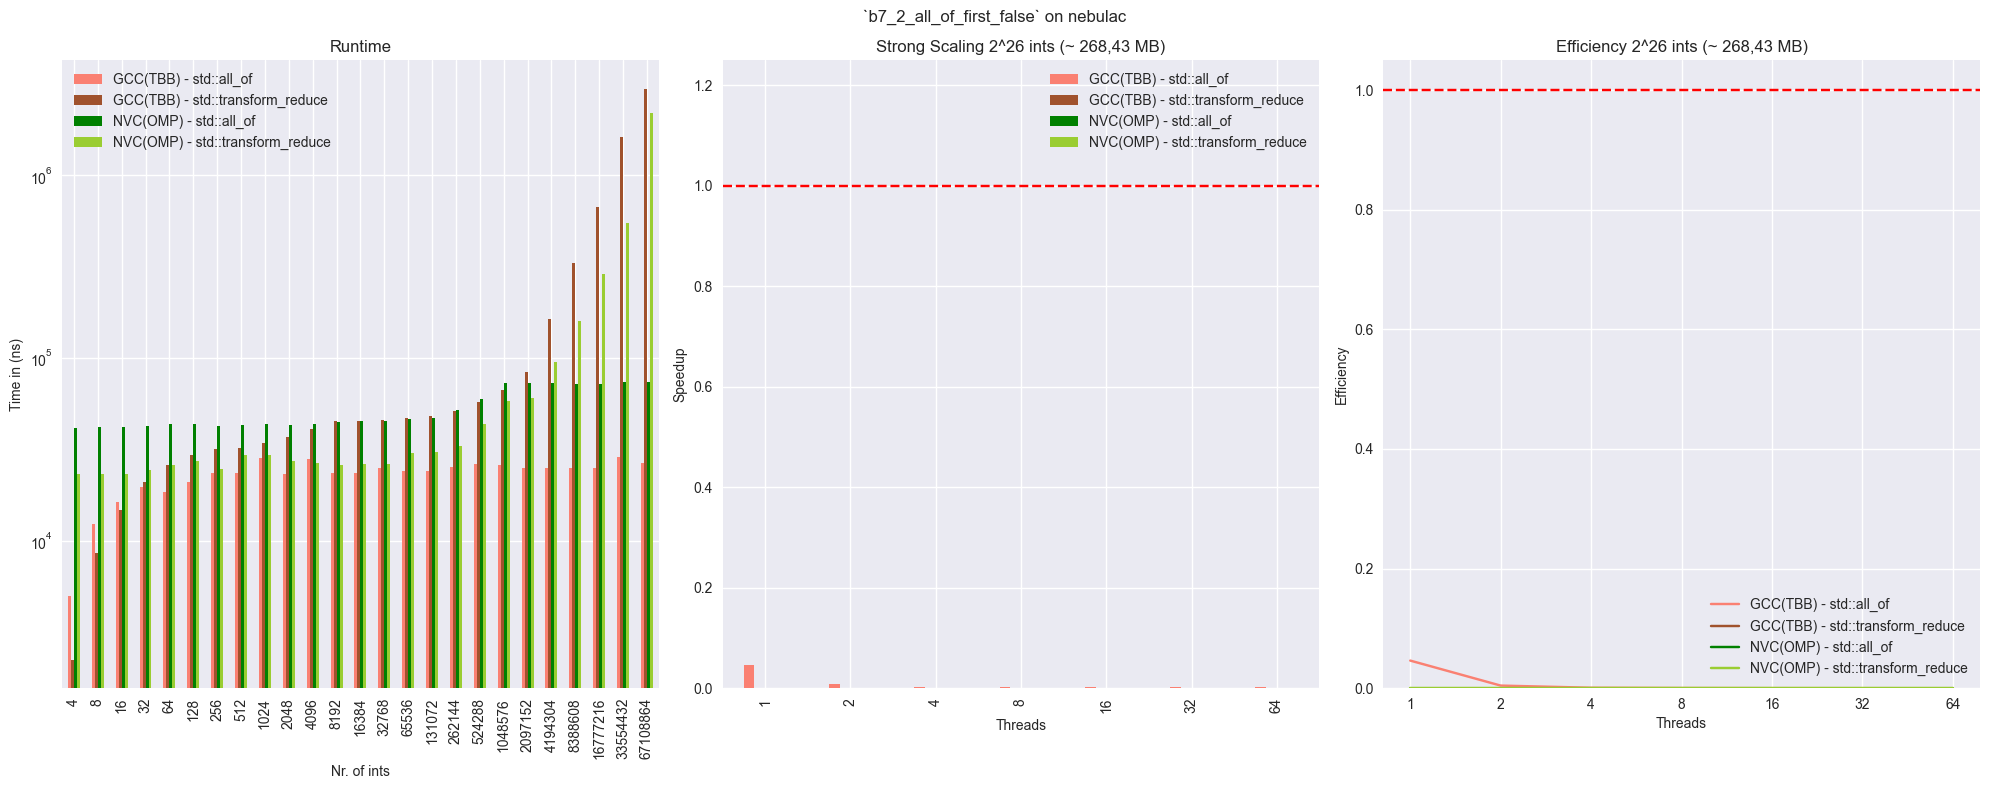

In [312]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_first_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_first_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,1.25)





# plot efficiency
ax_3 = b7_2_first_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_first_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_first_false` {device_name}")

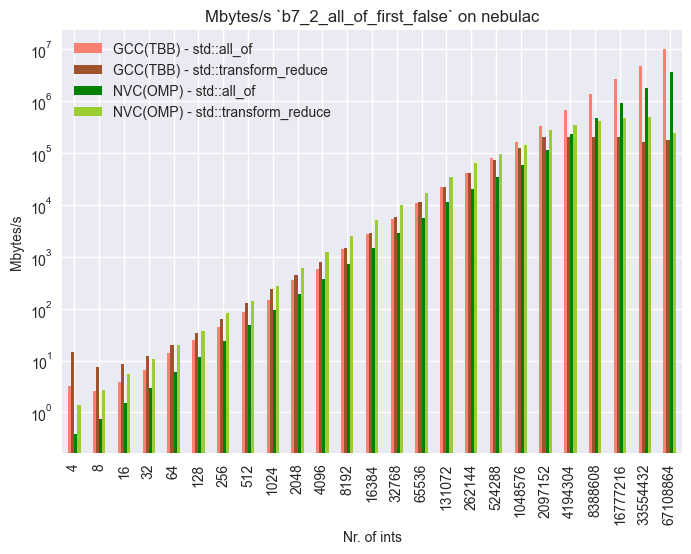

In [313]:

# mybtes graph


b7_2_first_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_first_false` on {device_name}')


plot(f'`b7_2_all_of_first_false` Mbytes_s on {device_name}')

## `b7_2` -  last_false

In [314]:
benchmark_names = [
    ("b7_2_all_of_last_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_last_false",'std::transform_reduce')
]

strong_scale_base = benchmark_names[0][0]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - last_false

Check how the runtime without constraining the threads develops with increasing input size

In [315]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_last_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_time_merged = pd.merge(b7_2_last_false_time_merged,data[i], on='n')

b7_2_last_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5321.76,4,2663.64,46637.3,20987.1
1,14860.90,8,5994.49,43870.1,21107.4
2,17193.70,16,11170.10,45922.1,21719.4
3,21936.80,32,18229.20,47237.4,22877.6
4,25405.80,64,23291.30,47458.9,23829.5
5,27489.20,128,26931.20,46156.6,23855.0
6,28623.80,256,28724.50,53324.1,23912.1
7,30165.90,512,30683.70,46899.6,24868.0
8,33232.10,1024,33976.30,53094.0,26268.1
9,36630.10,2048,37997.40,52922.2,26417.6


### Strong Scaling - last_false
 
2^26 fixed input size with threads 1-64

In [316]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_last_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_strong_scaling_merged = pd.merge(b7_2_last_false_strong_scaling_merged,data[i], on='threads')


b7_2_last_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.085433,0.699762,0.264288,0.425460
1,2,2.166918,1.416354,0.522263,0.850817
2,4,3.869319,2.776181,1.013815,1.700900
3,8,6.533751,4.905528,1.841224,3.387459
4,16,10.106389,8.296412,2.441687,6.738787
5,32,11.571023,10.726853,2.478612,12.532043
6,64,12.192212,10.390554,2.912864,23.151581


In [317]:
## efficiency graph

b7_2_last_false_efficiency = b7_2_last_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_last_false_efficiency['threads']

b7_2_last_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.085433,0.699762,0.264288,0.425460
1,2,1.083459,0.708177,0.261132,0.425408
2,4,0.967330,0.694045,0.253454,0.425225
3,8,0.816719,0.613191,0.230153,0.423432
4,16,0.631649,0.518526,0.152605,0.421174
5,32,0.361594,0.335214,0.077457,0.391626
6,64,0.190503,0.162352,0.045513,0.361743


### Mbytes/s

In [318]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_last_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_bytes_merged = pd.merge(b7_2_last_false_bytes_merged,data[i], on='n')

b7_2_last_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.00652,12.0136,0.343073,1.52474
1,8,2.15331,10.6765,0.729426,3.03211
2,16,3.72230,11.4591,1.393660,5.89334
3,32,5.83496,14.0434,2.709720,11.19000
4,64,10.07640,21.9825,5.394140,21.48600
5,128,18.62550,38.0229,11.092700,42.92600
6,256,35.77440,71.2981,19.203300,85.64710
7,512,67.89120,133.4910,43.667700,164.71000
8,1024,123.25400,241.1090,77.146200,311.86200
9,2048,223.64100,431.1870,154.793000,620.19300


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/3655766821.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


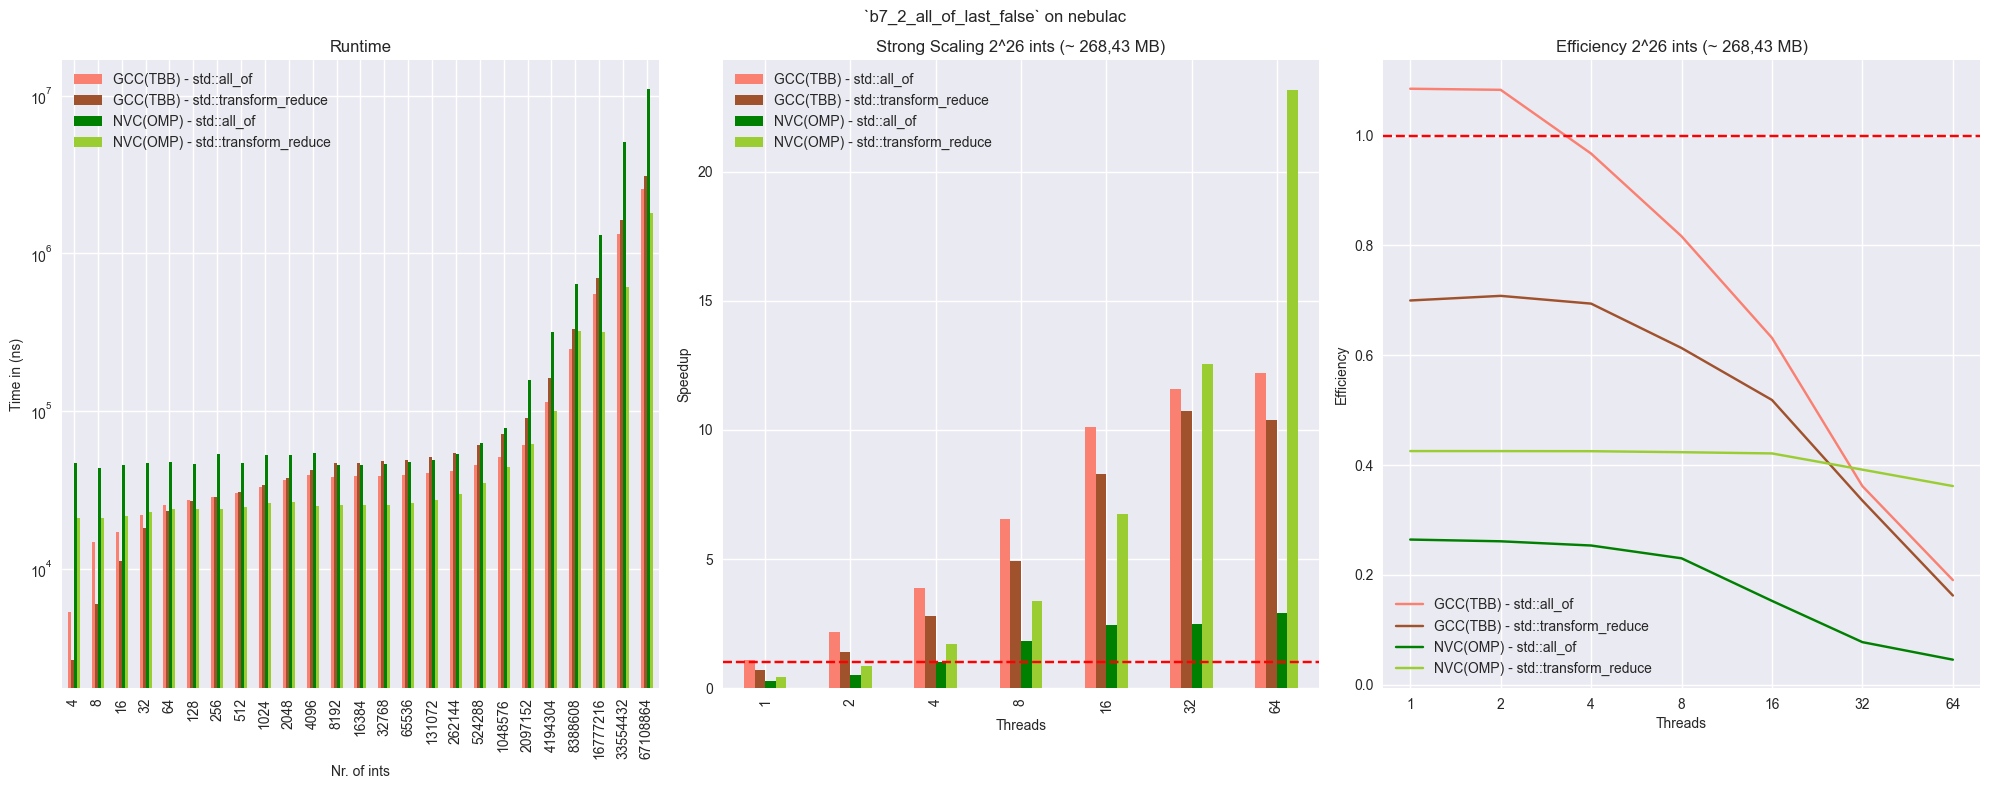

In [319]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_last_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_last_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_last_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_last_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_last_false` {device_name}")

<Axes: xlabel='threads'>

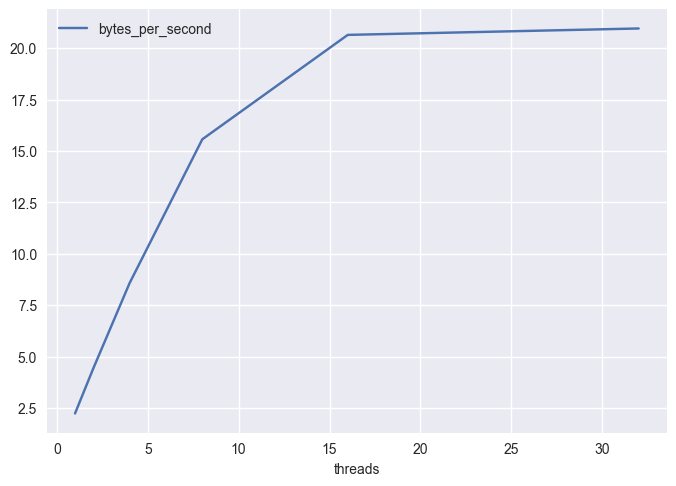

In [320]:
nvc_df = extraction_pandas_frame_algo_threaded(f'{root_dir}/NVHPC_Multicore/THREADS',
                                               f'b7_2_all_of_last_false_par',
                                               [1,2,4,8,16,32],
                                               COMP='NVC',
                                               include_bytes=True
)

nvc_df['bytes_per_second'] = nvc_df['bytes_per_second'] / 1_000_000_000
nvc_df.plot(x='threads',y='bytes_per_second')

Text(0.5, 1.0, 'b7_2_all_of_last_false \n2^26 ints (~ 268,43 MB)')

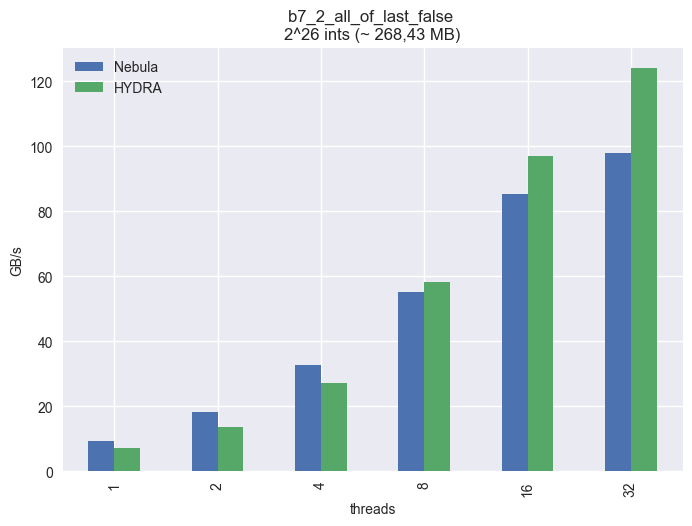

In [321]:
gcc_df = extraction_pandas_frame_algo_threaded(f'{root_dir}/GCC_TBB/THREADS',
                                               f'b7_2_all_of_last_false_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)






gcc_hydra_df = extraction_pandas_frame_algo_threaded(f'/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/GCC_TBB/THREADS',
                                               f'b7_2_all_of_last_false_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)




gcc_df['bytes_per_second'] = (gcc_df['bytes_per_second'] / 1_000_000_000)
gcc_hydra_df['bytes_per_second'] = (gcc_hydra_df['bytes_per_second'] / 1_000_000_000) 


gcc_df = gcc_df.rename(columns={'bytes_per_second': 'Nebula'})
gcc_hydra_df = gcc_hydra_df.rename(columns={'bytes_per_second': 'HYDRA'})


xx = pd.merge(gcc_df,gcc_hydra_df,on='threads')

xx = xx.drop(['name_x','real_time_x','cpu_time_x','time_unit_x',	'n_x'	,'median_x'	,'stddev_x'	,'Compiler_x',	'name_y'	,'real_time_y'	,'cpu_time_y',	'time_unit_y',	'n_y',	'median_y',	'stddev_y',	'Compiler_y'],axis=1)

ax = xx.plot(kind='bar',x='threads')
ax.set_ylabel('GB/s')
ax.set_title('b7_2_all_of_last_false \n2^26 ints (~ 268,43 MB)')


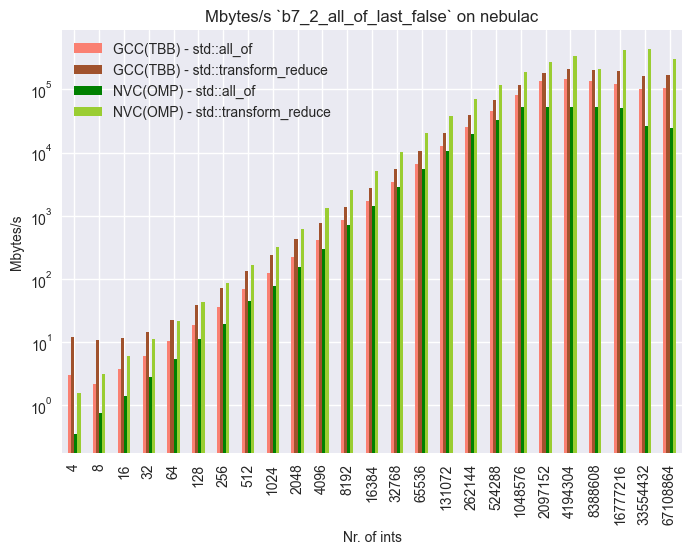

In [322]:
b7_2_last_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_last_false` on {device_name}')


plot(f'`b7_2_all_of_last_false` Mbytes_s on {device_name}')

## `b7_2` -  auto_false

In [323]:
benchmark_names = [
    ("b7_2_all_of_auto_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_auto_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_auto_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - auto_false

Check how the runtime without constraining the threads develops with increasing input size

In [324]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_auto_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_time_merged = pd.merge(b7_2_auto_false_time_merged,data[i], on='n')

b7_2_auto_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,6161.51,4,2592.21,39569.4,22210.8
1,12710.40,8,7154.64,39598.7,22169.0
2,15040.50,16,12865.70,41449.7,25803.9
3,17846.10,32,18488.60,46227.1,24859.0
4,18655.00,64,23542.10,46384.6,33637.8
5,22087.60,128,27334.50,46210.4,31814.2
6,24715.30,256,29309.40,46428.5,28634.5
7,30380.00,512,30702.90,46229.7,27546.3
8,30778.90,1024,33236.70,45710.6,27799.9
9,30494.60,2048,36256.00,45493.5,28668.3


### Strong Scaling - auto_false
 
2^26 fixed input size with threads 1-64

In [325]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_auto_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_strong_scaling_merged = pd.merge(b7_2_auto_false_strong_scaling_merged,data[i], on='threads')


b7_2_auto_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.044463,0.000005,0.000121,0.040625
1,2,0.012736,0.000010,0.000228,0.008551
2,4,0.005663,0.000020,0.000396,0.004370
3,8,0.003364,0.000038,0.000559,0.002626
4,16,0.002738,0.000071,0.000681,0.002047
5,32,0.002325,0.000126,0.000830,0.002032
6,64,0.002172,0.000208,0.000818,0.001747


In [326]:
## efficiency graph

b7_2_auto_false_efficiency = b7_2_auto_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_auto_false_efficiency['threads']

b7_2_auto_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.044463,0.000005,0.000121,0.040625
1,2,0.006368,0.000005,0.000114,0.004276
2,4,0.001416,0.000005,0.000099,0.001093
3,8,0.000421,0.000005,0.000070,0.000328
4,16,0.000171,0.000004,0.000043,0.000128
5,32,0.000073,0.000004,0.000026,0.000063
6,64,0.000034,0.000003,0.000013,0.000027


### Mbytes/s

In [327]:
# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_auto_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_bytes_merged = pd.merge(b7_2_auto_false_bytes_merged,data[i], on='n')

b7_2_auto_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,2.596770e+00,1.234470e+01,4.043520e-01,1.440740e+00
1,8,2.517620e+00,8.945240e+00,8.081070e-01,2.886910e+00
2,16,4.255180e+00,9.948910e+00,1.544040e+00,4.960490e+00
3,32,7.172450e+00,1.384640e+01,2.768940e+00,1.029810e+01
4,64,1.372290e+01,2.174820e+01,5.519080e+00,1.522100e+01
5,128,2.318050e+01,3.746180e+01,1.107970e+01,3.218680e+01
6,256,4.143190e+01,6.987510e+01,2.205540e+01,7.152200e+01
7,512,6.741270e+01,1.334080e+02,4.430050e+01,1.486950e+02
8,1024,1.330780e+02,2.464750e+02,8.960720e+01,2.946770e+02
9,2048,2.686370e+02,4.518970e+02,1.800700e+02,5.715010e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/1629545763.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


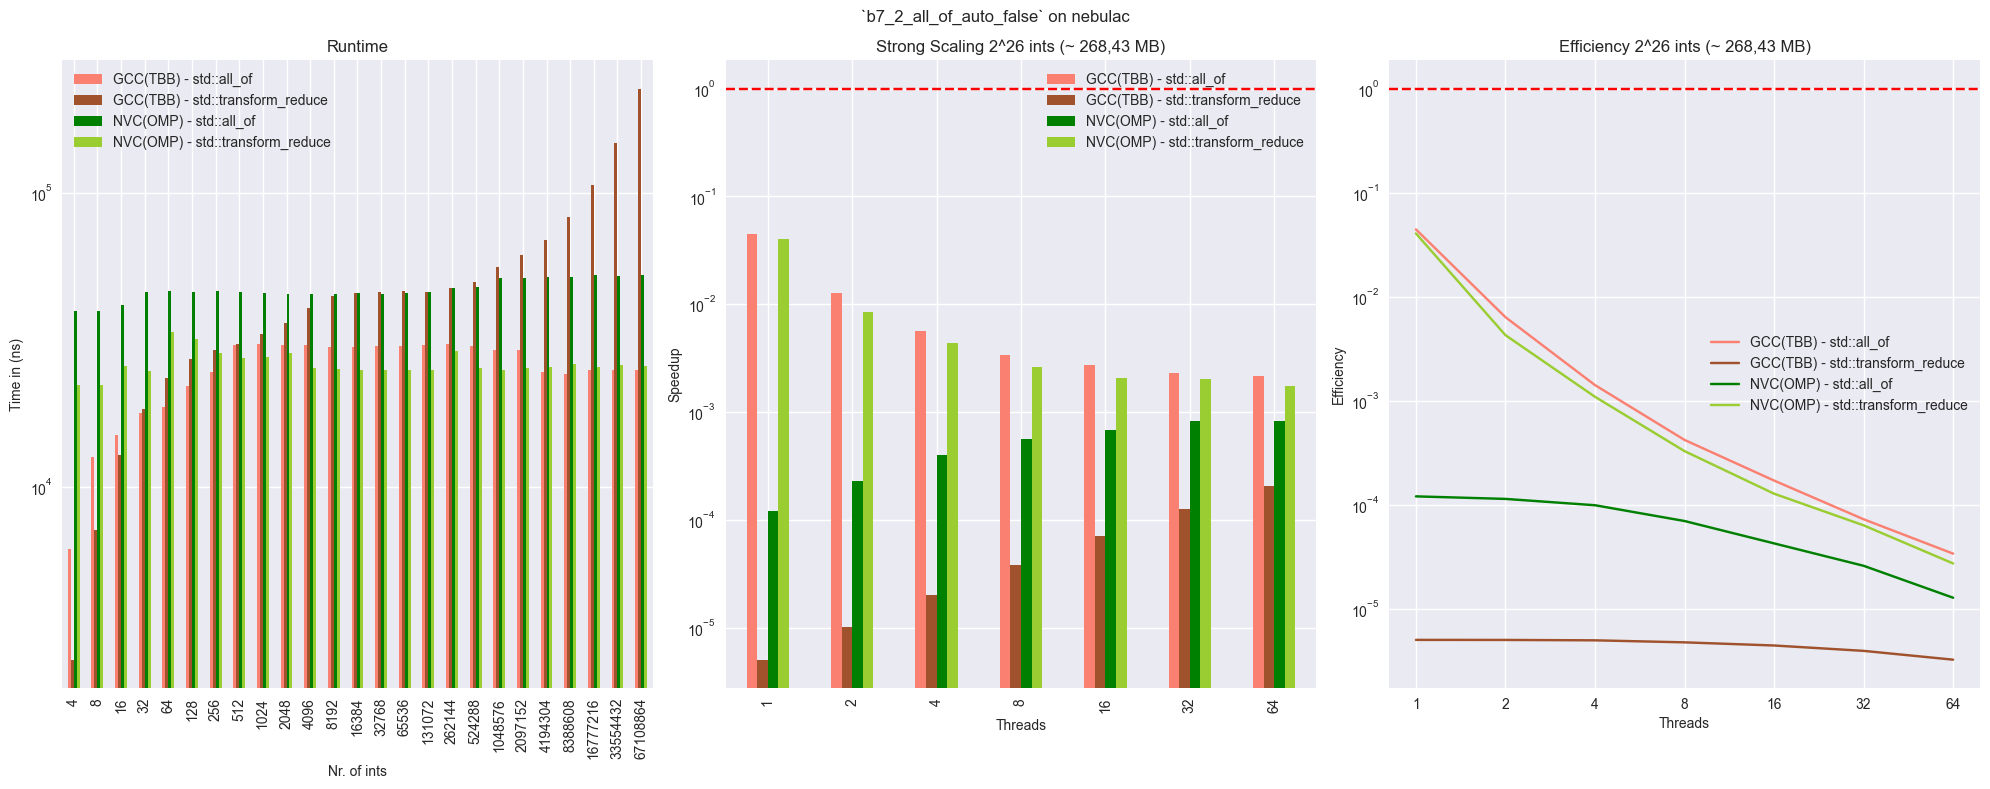

In [328]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_auto_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_auto_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# plot efficiency
ax_3 = b7_2_auto_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_yscale('log',base=10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_auto_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_auto_false` {device_name}")

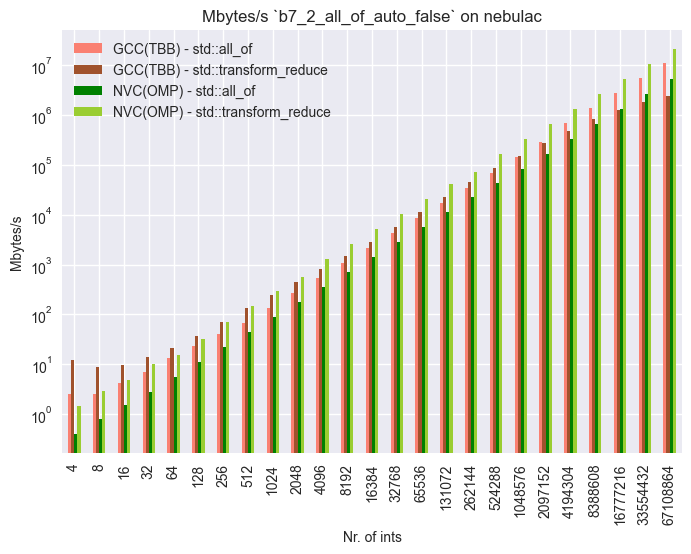

In [329]:

# mybtes graph

b7_2_auto_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_auto_false` on {device_name}')


plot(f'`b7_2_all_of_auto_false` Mbytes_s on {device_name}')

## `b7_3` -  all_hit

In [330]:
benchmark_names = [
    ("b7_3_count_if_all_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_all_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_all_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_all_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_hit

Check how the runtime without constraining the threads develops with increasing input size

In [331]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_all_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_time_merged = pd.merge(b7_3_all_hit_time_merged,data[i], on='n')

b7_3_all_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,5082.02,4,2692.97,25031.1,21086.6
1,14340.60,8,7444.06,23925.3,20691.0
2,20486.20,16,13024.50,24384.5,21031.6
3,24097.40,32,18879.30,25786.4,22072.8
4,28931.60,64,24035.20,25813.2,22589.3
5,33856.90,128,27893.40,24497.7,24233.6
6,43858.20,256,29846.80,24483.6,24526.8
7,45647.90,512,30997.80,24469.5,24973.2
8,48257.10,1024,33474.50,25368.2,26761.9
9,52831.60,2048,36622.80,25701.9,24371.7


### Strong Scaling - all_hit
 
2^26 fixed input size with threads 1-64

In [332]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_all_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_strong_scaling_merged = pd.merge(b7_3_all_hit_strong_scaling_merged,data[i], on='threads')


b7_3_all_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.059014,0.492463,0.900508,1.474030
1,2,2.044396,0.994463,1.811535,2.593305
2,4,3.221828,1.956212,3.591343,5.807916
3,8,4.579960,3.378980,6.851951,10.212024
4,16,6.407473,5.992646,12.274888,15.654346
5,32,7.321876,7.078135,16.284548,15.008623
6,64,7.604006,7.767329,13.267899,20.506500


In [333]:
## efficiency graph

b7_3_all_hit_efficiency = b7_3_all_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_all_hit_efficiency['threads']

b7_3_all_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.059014,0.492463,0.900508,1.474030
1,2,1.022198,0.497232,0.905767,1.296653
2,4,0.805457,0.489053,0.897836,1.451979
3,8,0.572495,0.422372,0.856494,1.276503
4,16,0.400467,0.374540,0.767180,0.978397
5,32,0.228809,0.221192,0.508892,0.469019
6,64,0.118813,0.121365,0.207311,0.320414


### Mbytes/s

In [334]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_all_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_bytes_merged = pd.merge(b7_3_all_hit_bytes_merged,data[i], on='n')

b7_3_all_hit_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,3.14835,5.94140,0.639204,7.587770e-01
1,8,2.23142,4.29873,1.337490,1.546570e+00
2,16,3.12406,4.91380,2.624620,3.043040e+00
3,32,5.31178,6.77991,4.963860,5.798990e+00
4,64,8.84846,10.65100,9.917420,1.133280e+01
5,128,15.12250,18.35560,20.899900,2.112770e+01
6,256,23.34790,34.30850,41.823900,4.175020e+01
7,512,44.86520,66.06910,83.696000,8.200790e+01
8,1024,84.87870,122.36200,161.462000,1.530530e+02
9,2048,155.05900,223.68600,318.731000,3.361280e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/3164471847.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


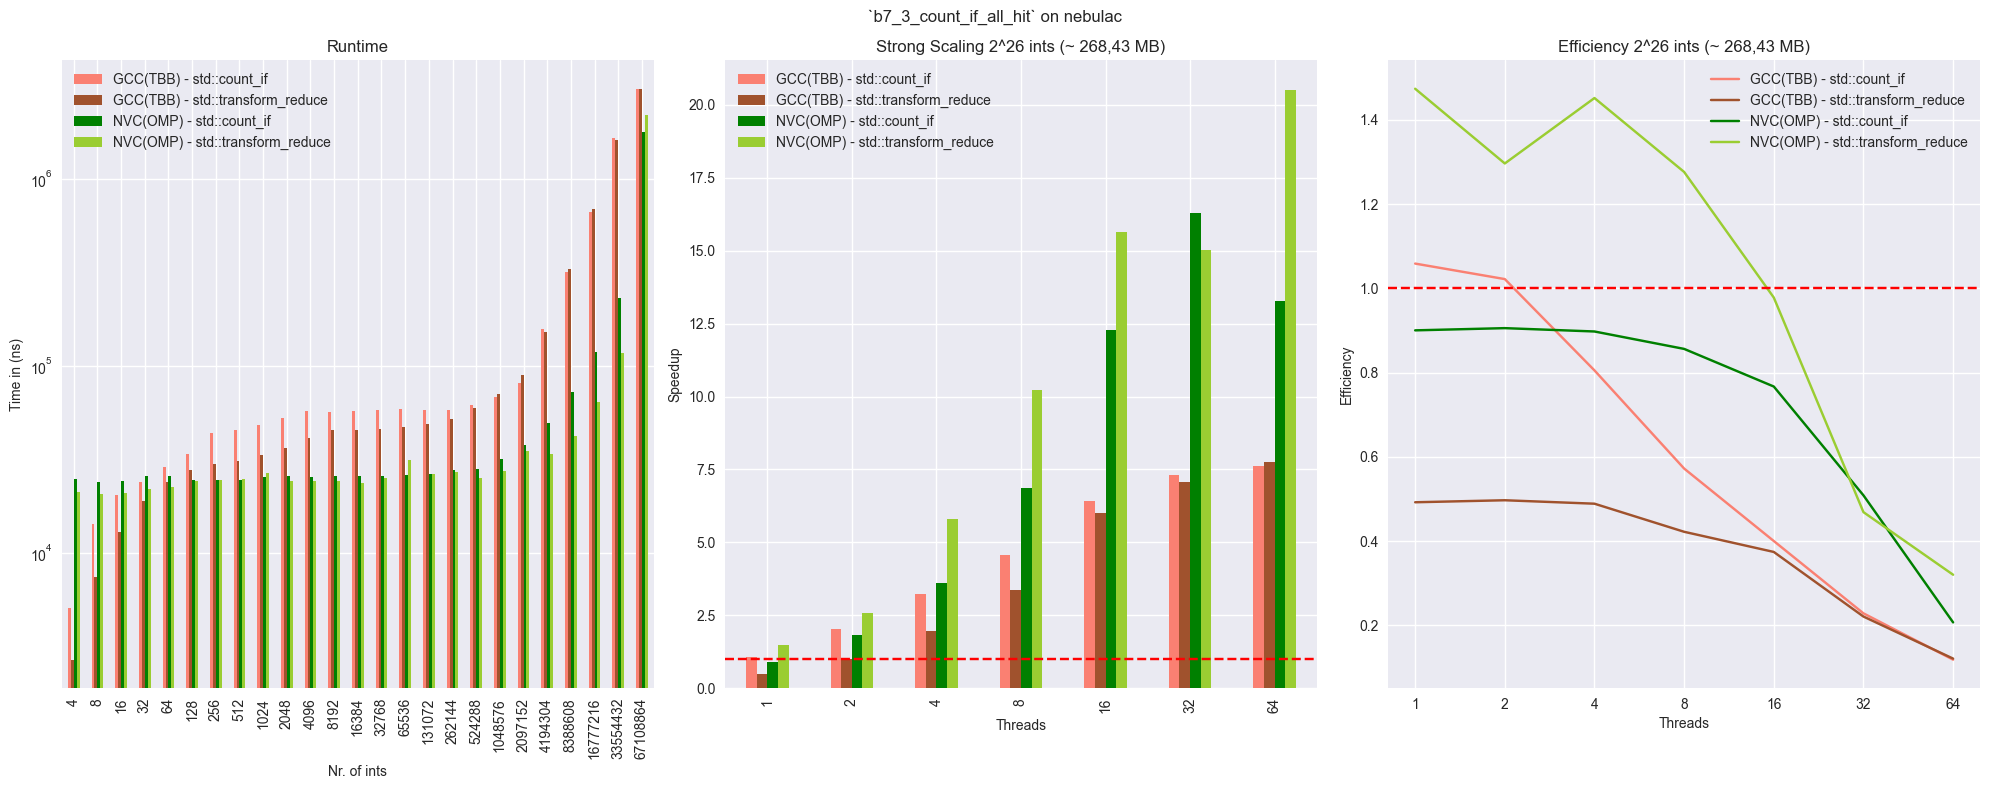

In [335]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_all_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_all_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_all_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')

fig.suptitle(f"`b7_3_count_if_all_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_all_hit` {device_name}")

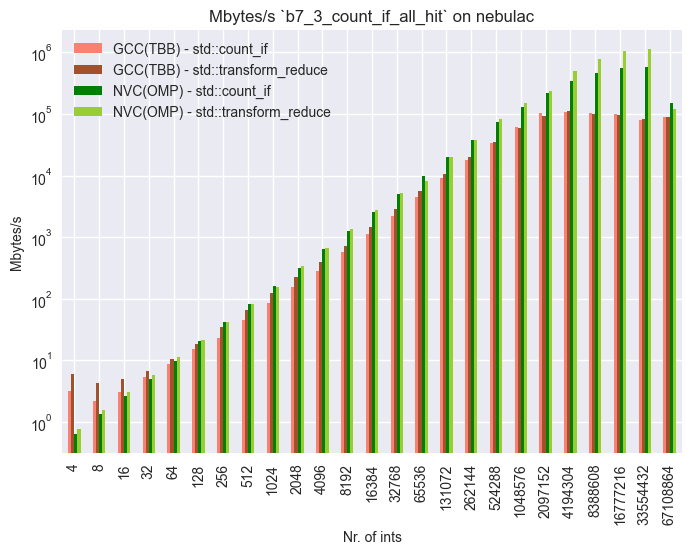

In [336]:
# mybtes graph

b7_3_all_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_all_hit` on {device_name}')


plot(f'`b7_3_count_if_all_hit` Mbytes_s on {device_name}')

## `b7_3` -  half_hit

In [337]:
benchmark_names = [
    ("b7_3_count_if_half_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_half_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_half_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_half_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - half_hit

Check how the runtime without constraining the threads develops with increasing input size

In [338]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_half_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_time_merged = pd.merge(b7_3_half_hit_time_merged,data[i], on='n')

b7_3_half_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6440.07,4,2589.63,24314.6,22183.1
1,12064.40,8,9554.82,23837.0,21912.5
2,20718.20,16,14319.50,23899.5,22469.3
3,26137.30,32,16210.80,24484.3,22183.3
4,30583.80,64,21160.00,23445.6,24622.5
5,32738.70,128,26383.50,24798.2,24056.5
6,34738.90,256,29354.70,24160.1,24103.2
7,37748.60,512,36479.90,23816.8,24027.0
8,41601.50,1024,34025.10,23997.4,23959.1
9,47165.40,2048,37195.20,23791.4,24074.3


### Strong Scaling - half_hit
 
2^26 fixed input size with threads 1-64

In [339]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_half_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_strong_scaling_merged = pd.merge(b7_3_half_hit_strong_scaling_merged,data[i], on='threads')


b7_3_half_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.014511,0.466217,0.797169,1.369169
1,2,1.930006,0.944563,1.603732,2.417649
2,4,3.019472,1.863983,3.168613,4.787090
3,8,4.246113,3.203829,6.143484,9.282515
4,16,6.098880,5.629848,11.336314,16.651524
5,32,6.728987,6.848200,15.409197,11.756811
6,64,6.993927,7.312139,14.435575,15.971768


In [340]:
## efficiency graph

b7_3_half_hit_efficiency = b7_3_half_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_half_hit_efficiency['threads']

b7_3_half_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.014511,0.466217,0.797169,1.369169
1,2,0.965003,0.472282,0.801866,1.208824
2,4,0.754868,0.465996,0.792153,1.196772
3,8,0.530764,0.400479,0.767936,1.160314
4,16,0.381180,0.351866,0.708520,1.040720
5,32,0.210281,0.214006,0.481537,0.367400
6,64,0.109280,0.114252,0.225556,0.249559


### Mybtes/s

In [341]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_half_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_bytes_merged = pd.merge(b7_3_half_hit_bytes_merged,data[i], on='n')

b7_3_half_hit_bytes_merged


,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,2.48444,6.17849,0.658041,7.212710e-01
1,8,2.65243,3.34909,1.342450,1.460350e+00
2,16,3.08907,4.46944,2.677880,2.848330e+00
3,32,4.89722,7.89597,5.227840,5.770100e+00
4,64,8.37044,12.09830,10.918900,1.039700e+01
5,128,15.63900,19.40610,20.646600,2.128320e+01
6,256,29.47700,34.88370,42.384000,4.248390e+01
7,512,54.25370,56.14050,85.989700,8.523740e+01
8,1024,98.45790,120.38200,170.685000,1.709580e+02
9,2048,173.68700,220.24300,344.325000,3.402790e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/4180608575.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


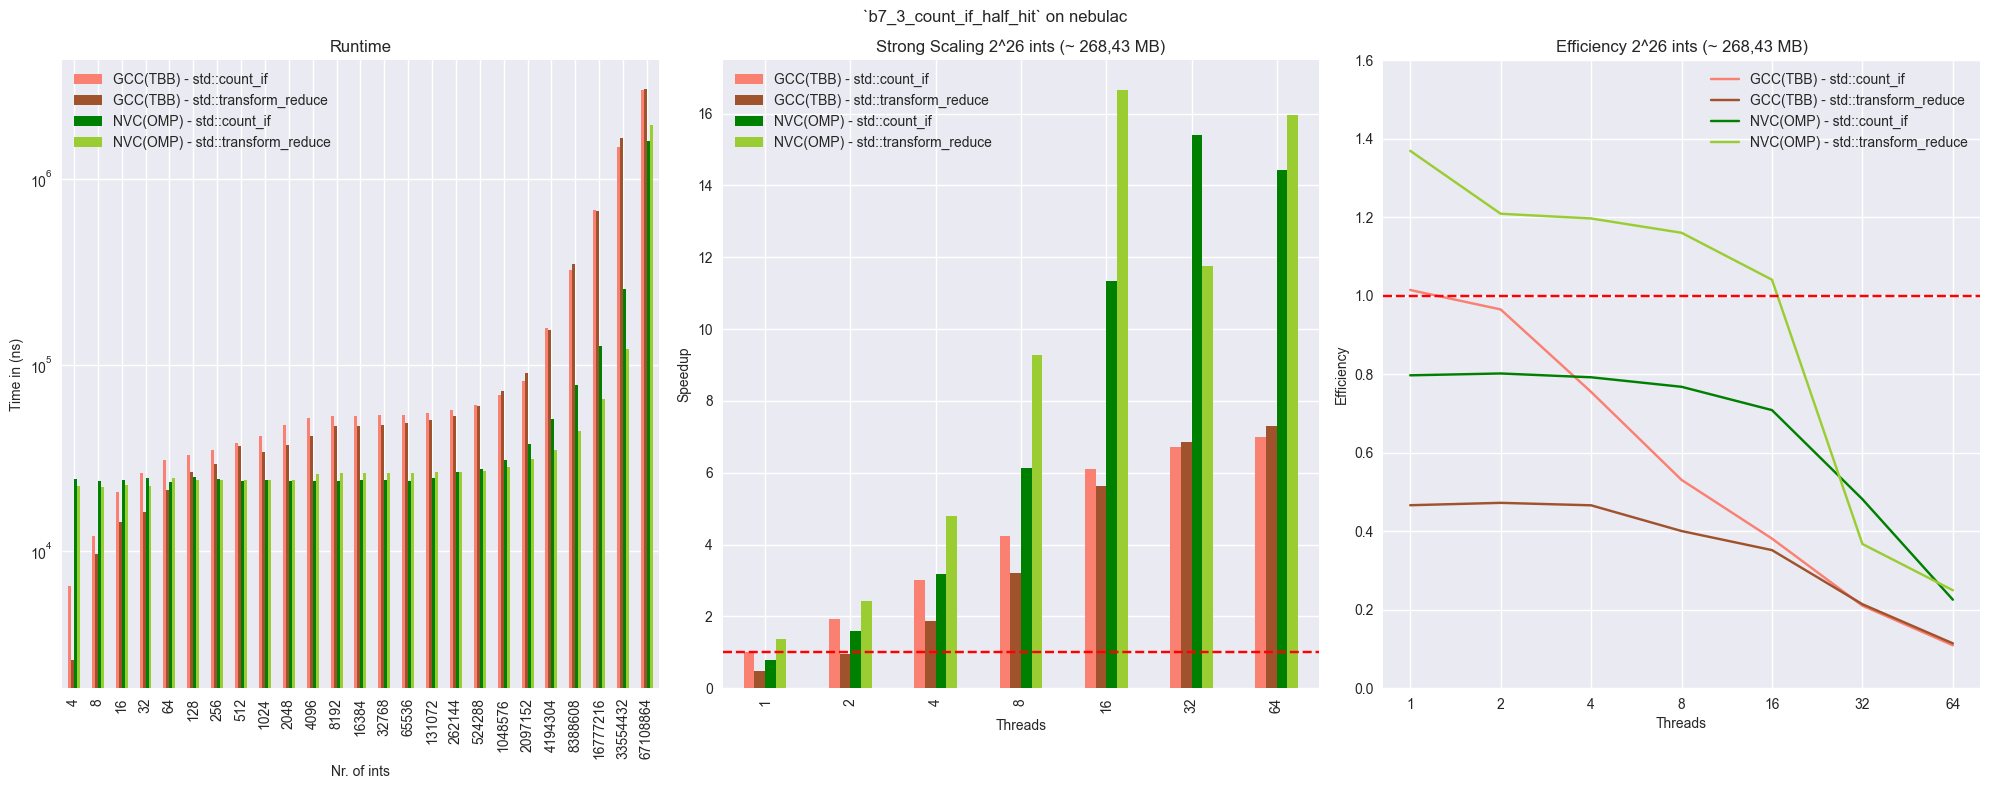

In [342]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_half_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_half_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_half_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')
ax_3.set_ylim(0,1.6)


fig.suptitle(f"`b7_3_count_if_half_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_half_hit` {device_name}")

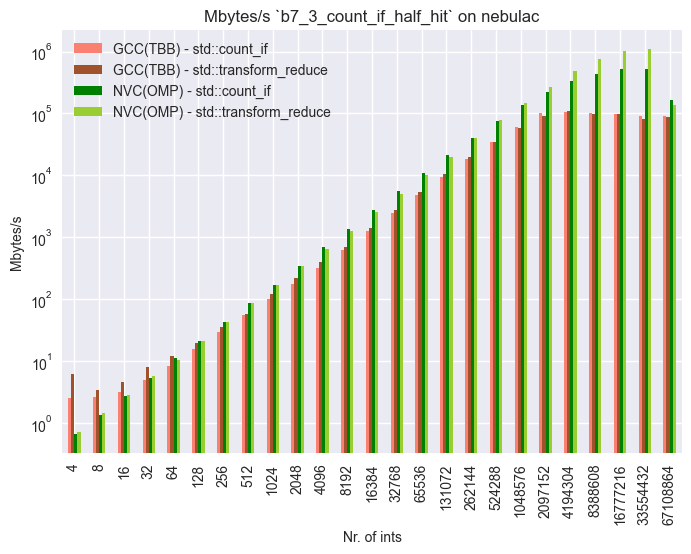

In [343]:
# mybtes graph

b7_3_half_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_half_hit` Mbytes_s on {device_name}')

## `b7_3` -  orders_struct

In [344]:
benchmark_names = [
    ("b7_3_count_if_orders_struct",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_orders_struct",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_orders_struct",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_orders_struct'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - orders_struct

Check how the runtime without constraining the threads develops with increasing input size

In [345]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_orders_struct_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_time_merged = pd.merge(b7_3_orders_struct_time_merged,data[i], on='n')

b7_3_orders_struct_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,6011.22,4,2532.12,23493.8,24467.0
1,14069.50,8,8493.75,23866.1,24184.0
2,20380.40,16,15054.70,23412.7,23774.8
3,25267.50,32,21399.20,23704.6,26101.4
4,28928.90,64,26278.50,23780.6,25788.5
5,32997.30,128,30046.50,23736.7,24916.3
6,32124.90,256,32692.10,25062.9,24975.8
7,35012.60,512,31081.90,25180.9,25244.5
8,38573.90,1024,33524.30,25219.8,25396.6
9,42758.60,2048,36986.10,24311.9,25331.8


### Strong Scaling - orders_struct
 
2^26 fixed input size with threads 1-64

In [346]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_orders_struct_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_strong_scaling_merged = pd.merge(b7_3_orders_struct_strong_scaling_merged,data[i], on='threads')


b7_3_orders_struct_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.001870,0.551288,0.991114,1.044353
1,2,1.913947,1.116247,1.935670,2.083743
2,4,3.058345,2.006175,3.919808,4.199859
3,8,4.292561,3.482364,7.495883,8.166349
4,16,5.748848,5.470120,14.374701,14.981337
5,32,6.281182,6.398621,19.623432,21.039094
6,64,6.767223,6.663870,16.352002,18.789596


In [347]:
## efficiency graph

b7_3_orders_struct_efficiency = b7_3_orders_struct_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] = b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] / b7_3_orders_struct_efficiency['threads']

b7_3_orders_struct_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.001870,0.551288,0.991114,1.044353
1,2,0.956973,0.558124,0.967835,1.041872
2,4,0.764586,0.501544,0.979952,1.049965
3,8,0.536570,0.435296,0.936985,1.020794
4,16,0.359303,0.341882,0.898419,0.936334
5,32,0.196287,0.199957,0.613232,0.657472
6,64,0.105738,0.104123,0.255500,0.293587


### Mbytes/s

In [348]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_orders_struct_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_bytes_merged = pd.merge(b7_3_orders_struct_bytes_merged,data[i], on='n')

b7_3_orders_struct_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,5.32338,12.63770,1.36206,1.30789
1,8,4.54884,7.53495,2.68163,2.64638
2,16,6.28055,8.50235,5.46711,5.38385
3,32,10.13160,11.96300,10.79960,9.80792
4,64,17.69860,19.48360,21.53020,19.85380
5,128,31.03280,34.08050,43.13990,41.09760
6,256,63.75120,62.64500,81.71460,81.99940
7,512,116.98700,131.78100,162.66300,162.25300
8,1024,212.37100,244.36000,324.82400,322.56300
9,2048,383.17400,442.97700,673.90900,646.77700


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/2492568009.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


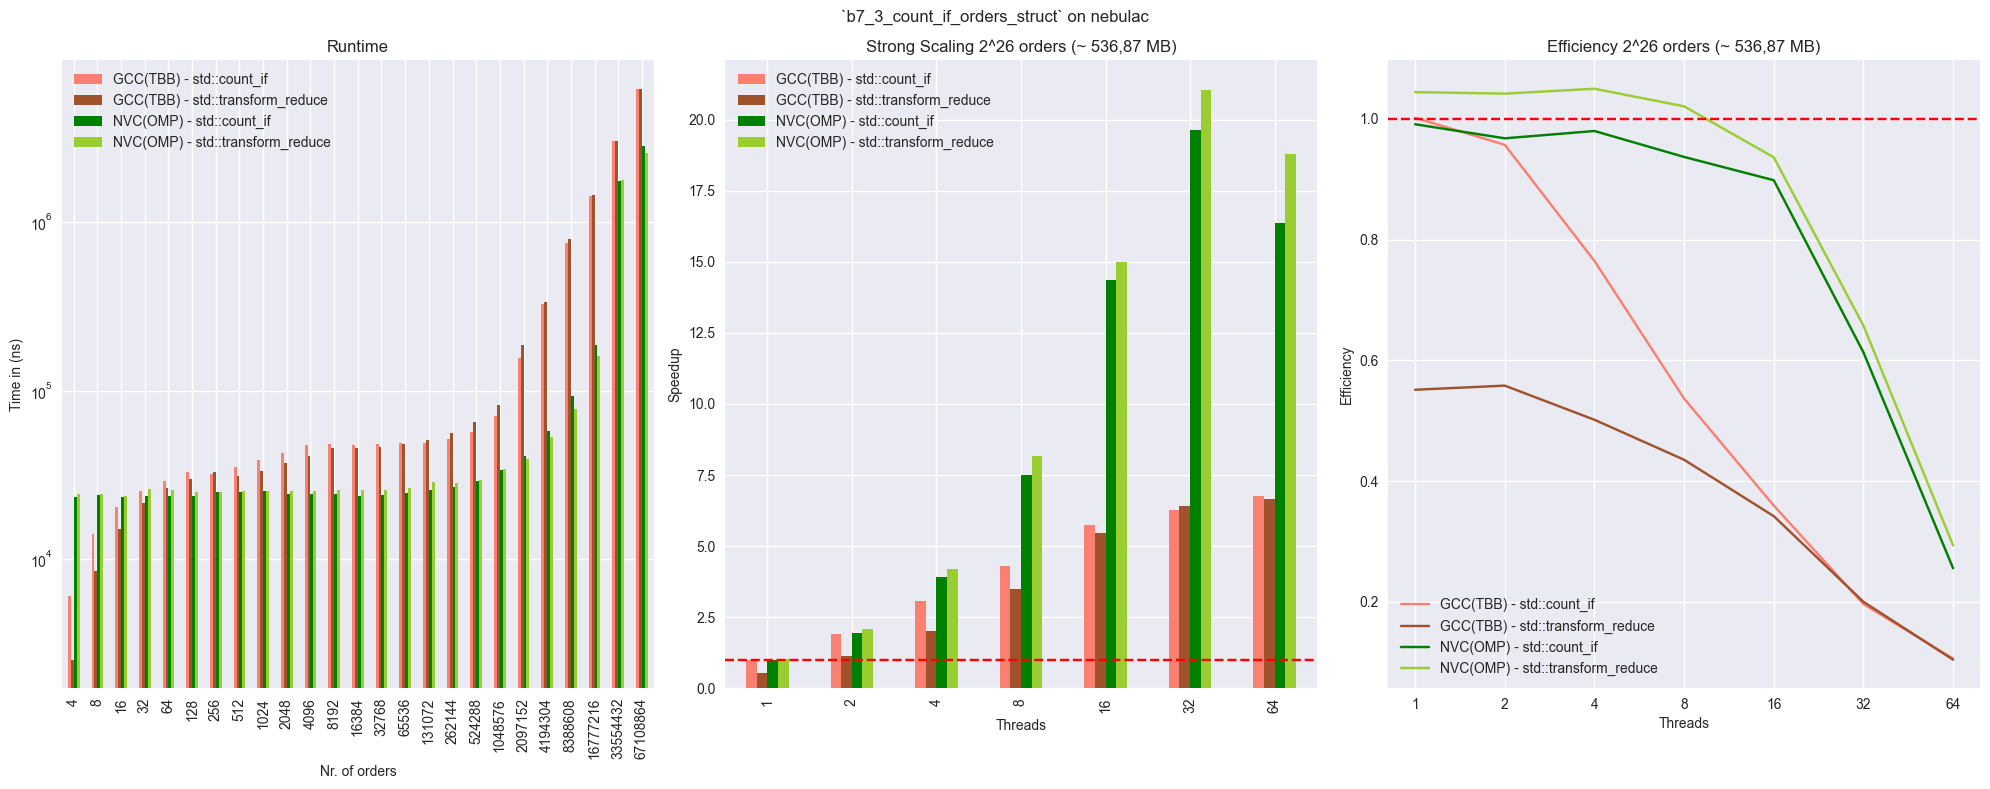

In [349]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_orders_struct_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of orders')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_orders_struct_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 orders (~ 536,87 MB)')





# plot efficiency
ax_3 = b7_3_orders_struct_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 orders (~ 536,87 MB)')


fig.suptitle(f"`b7_3_count_if_orders_struct` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_orders_struct` {device_name}")

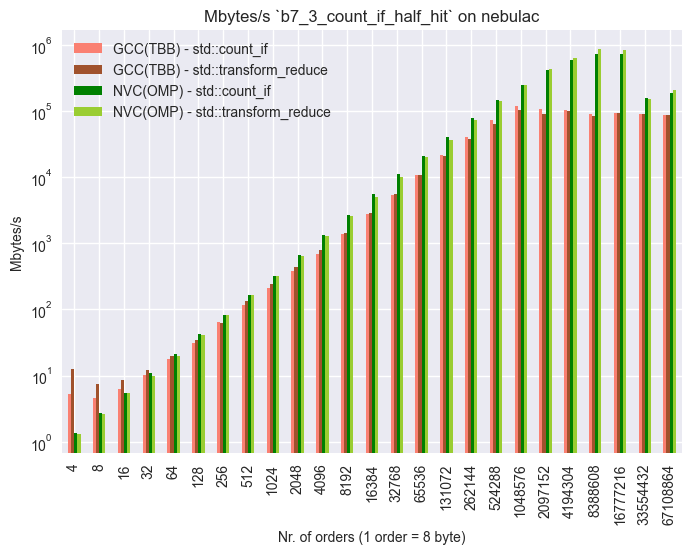

In [350]:
# mybtes graph

b7_3_orders_struct_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of orders (1 order = 8 byte)')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_orders_struct` Mbytes_s on {device_name}')

## `b7_4` - stencil transform 

In [351]:
benchmark_names = [
    ("b7_4_stencil_transform_number_to_neightbours_stdev",'std::transform'),
    ("b7_4_stencil_for_each_to_neightbours_stdev",'std::for_each')
]

strong_scale_base = benchmark_names[1][0]

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [352]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_4_stencil_time_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_time_merged = pd.merge(b7_4_stencil_time_merged,data[i], on='n')

b7_4_stencil_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,2830.11,4,2626.33,10341.1,11178.7
1,10595.80,8,12932.30,10181.4,10920.3
2,17995.10,16,21786.00,10823.7,11590.5
3,22865.50,32,26650.00,10990.4,11933.0
4,26555.30,64,30111.40,11995.6,12054.9
5,27961.50,128,31346.40,11404.7,11570.4
6,30934.40,256,32698.80,10702.3,12387.9
7,34323.50,512,35989.40,11330.9,11955.9
8,38438.10,1024,39422.60,10544.3,10808.7
9,43486.50,2048,44578.00,10517.6,11371.5


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [353]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of='b7_4_stencil_for_each_to_neightbours_stdev'
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_4_stencil_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_strong_scaling_merged = pd.merge(b7_4_stencil_strong_scaling_merged,data[i], on='threads')


b7_4_stencil_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.754992,0.710450,1.044229,0.538395
1,2,1.510474,1.419190,2.087555,1.073801
2,4,2.981024,2.830905,4.172559,2.147340
3,8,6.025364,5.650251,8.335531,4.292123
4,16,11.984816,11.252968,16.648906,8.282625
5,32,19.511629,19.485815,33.088839,16.373776
6,64,20.801283,20.905338,49.556138,31.351802


In [354]:
## efficiency graph

b7_4_stencil_efficiency = b7_4_stencil_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] = b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] / b7_4_stencil_efficiency['threads']

b7_4_stencil_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.754992,0.710450,1.044229,0.538395
1,2,0.755237,0.709595,1.043777,0.536901
2,4,0.745256,0.707726,1.043140,0.536835
3,8,0.753171,0.706281,1.041941,0.536515
4,16,0.749051,0.703311,1.040557,0.517664
5,32,0.609738,0.608932,1.034026,0.511680
6,64,0.325020,0.326646,0.774315,0.489872


### Mbytes/s

In [355]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_4_stencil_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_bytes_merged = pd.merge(b7_4_stencil_bytes_merged,data[i], on='n')

b7_4_stencil_bytes_merged


,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,21.2006,22.8455,5.80211,5.36734
1,8,11.7027,9.5884,12.17910,11.35500
2,16,14.0038,11.5671,23.28220,21.74190
3,32,22.2169,19.0619,46.22210,42.57100
4,64,38.4104,33.8742,85.03140,84.61290
5,128,73.1006,65.2069,179.22400,176.65800
6,256,132.2800,125.1420,382.34900,330.32200
7,512,238.5540,227.5110,722.62500,684.84800
8,1024,426.1390,415.4980,1553.44000,1515.45000
9,2048,753.4300,734.9810,3115.17000,2881.23000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/1698835649.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


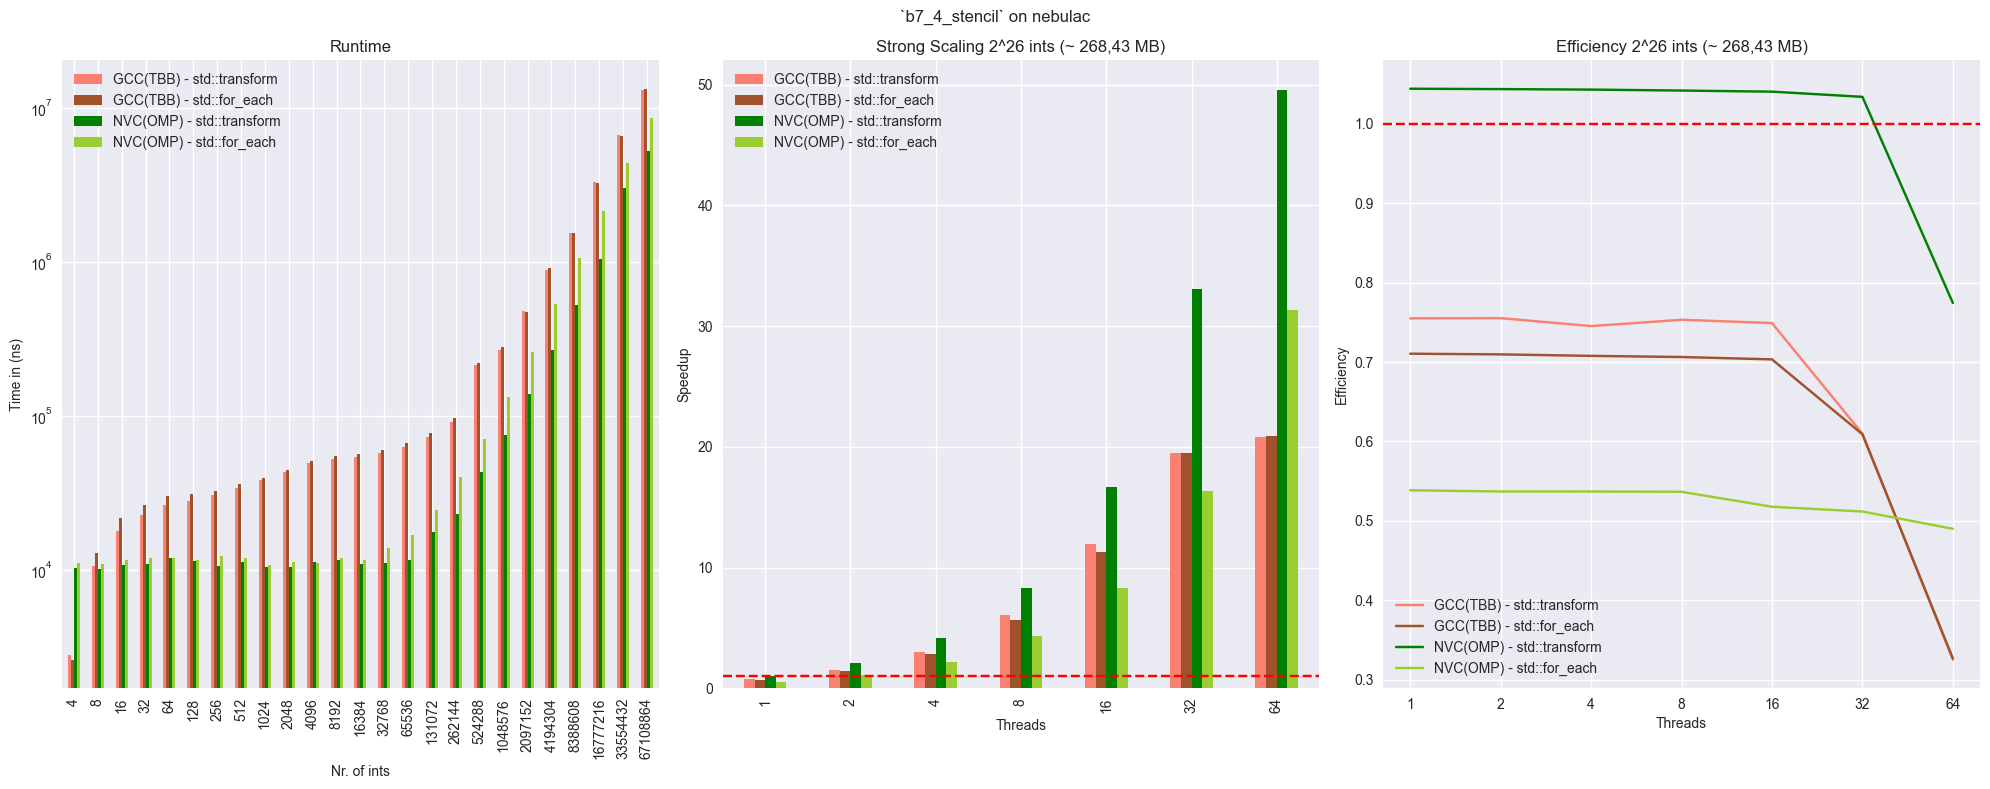

In [356]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_4_stencil_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_4_stencil_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')

#ax_2.set_ylim(0,2.5)



# plot efficiency
ax_3 = b7_4_stencil_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_4_stencil` on {device_name}")

fig.tight_layout()

plot(f"`b7_4_stencil` {device_name}")

In [357]:
nv_test = extraction_pandas_frame_algo(root_dir+'/NVHPC_Multicore/DEFAULT/b7_4_stencil_transform_number_to_neightbours_stdev_seq__Default.csv',include_bytes_per_second=True)
nv_test['bytes_per_second'] = int(nv_test['bytes_per_second'])

nv_test

,name,real_time,cpu_time,time_unit,bytes_per_second,n,median,stddev,Compiler
0,NVHPC_Multicore_b7_4_stencil_transform_number_...,60367800.0,60390500.0,ns,17786700000,67108864,60391900.0,14668.2,COMP


In [358]:
gcc_test = extraction_pandas_frame_algo(root_dir+'/GCC_TBB/DEFAULT/b7_4_stencil_transform_number_to_neightbours_stdev_seq__Default.csv',include_bytes_per_second=True)
gcc_test['bytes_per_second'] = int(gcc_test['bytes_per_second'])

gcc_test

,name,real_time,cpu_time,time_unit,bytes_per_second,n,median,stddev,Compiler
0,GCC_TBB_b7_4_stencil_transform_number_to_neigh...,363268000.0,363473000.0,ns,2955790000,67108864,363468000.0,116767.0,COMP


In [359]:
gcc_test['bytes_per_second']- nv_test['bytes_per_second']
# nv has better performance on hydra

0   -14830910000
Name: bytes_per_second, dtype: int64

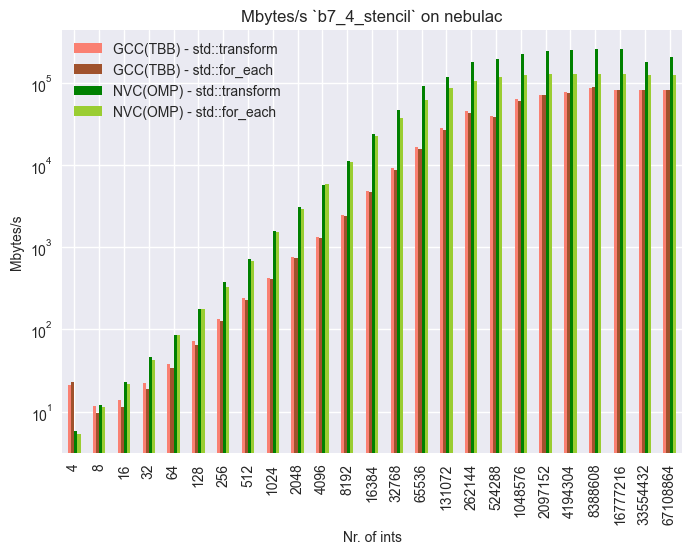

In [360]:

# mbytes graph

b7_4_stencil_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_4_stencil` on {device_name}')


plot(f'`b7_4_stencil` Mbytes_s on {device_name}')

## `b7_5` - Scalar Transform 

In [361]:
benchmark_names = [
    ("b7_5_scalar_transform_number",'std::transform'),
    ("b7_5_scalar_for_each",'std::for_each')
]

strong_scale_base = 'b7_5_scalar_transform_number'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [362]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_5_scalar_transform_time_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_time_merged = pd.merge(b7_5_scalar_transform_time_merged,data[i], on='n')

b7_5_scalar_transform_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,5524.32,4,4947.26,11652.7,10103.80
1,10618.20,8,10941.20,11742.6,9968.79
2,18087.50,16,17146.40,11051.2,10505.60
3,23459.70,32,22271.80,11861.5,11413.50
4,27271.00,64,31894.80,14023.7,12833.10
5,29011.00,128,33656.20,12557.1,11804.50
6,31519.20,256,35628.80,11826.4,11455.70
7,34719.70,512,37863.40,12009.3,10901.60
8,38198.10,1024,40455.20,11956.2,11286.40
9,43551.00,2048,44772.90,11952.2,10382.90


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [363]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_5_scalar_transform_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_strong_scaling_merged = pd.merge(b7_5_scalar_transform_strong_scaling_merged,data[i], on='threads')


b7_5_scalar_transform_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.015229,0.345009,0.114681,0.056112
1,2,1.339739,0.619531,0.229103,0.118919
2,4,3.091656,1.128547,0.457537,0.218059
3,8,3.561620,2.060614,0.913327,0.429054
4,16,4.562112,2.936184,1.826462,0.879205
5,32,4.766164,3.442266,3.637021,1.889575
6,64,4.820545,3.654205,7.211548,3.636082


In [364]:
## efficiency graph

b7_5_scalar_transform_efficiency = b7_5_scalar_transform_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] = b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] / b7_5_scalar_transform_efficiency['threads']

b7_5_scalar_transform_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.015229,0.345009,0.114681,0.056112
1,2,0.669870,0.309765,0.114552,0.059459
2,4,0.772914,0.282137,0.114384,0.054515
3,8,0.445203,0.257577,0.114166,0.053632
4,16,0.285132,0.183512,0.114154,0.054950
5,32,0.148943,0.107571,0.113657,0.059049
6,64,0.075321,0.057097,0.112680,0.056814


### Mbytes/s

In [365]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_5_scalar_transform_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_bytes_merged = pd.merge(b7_5_scalar_transform_bytes_merged,data[i], on='n')

b7_5_scalar_transform_bytes_merged

,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,5.79257,6.46822,2.74615,3.16712
1,8,6.02738,5.84946,5.45025,6.42004
2,16,7.07670,7.46514,11.58250,12.18400
3,32,10.91230,11.49440,21.58240,22.42950
4,64,18.77450,16.05280,36.50970,39.89690
5,128,35.29690,30.42530,81.54740,86.74660
6,256,64.97630,57.48150,173.17100,178.77500
7,512,117.97300,108.17800,341.07000,375.72300
8,1024,214.46100,202.49600,685.16900,725.83100
9,2048,376.20300,365.93600,1370.79000,1577.98000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/3247401511.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


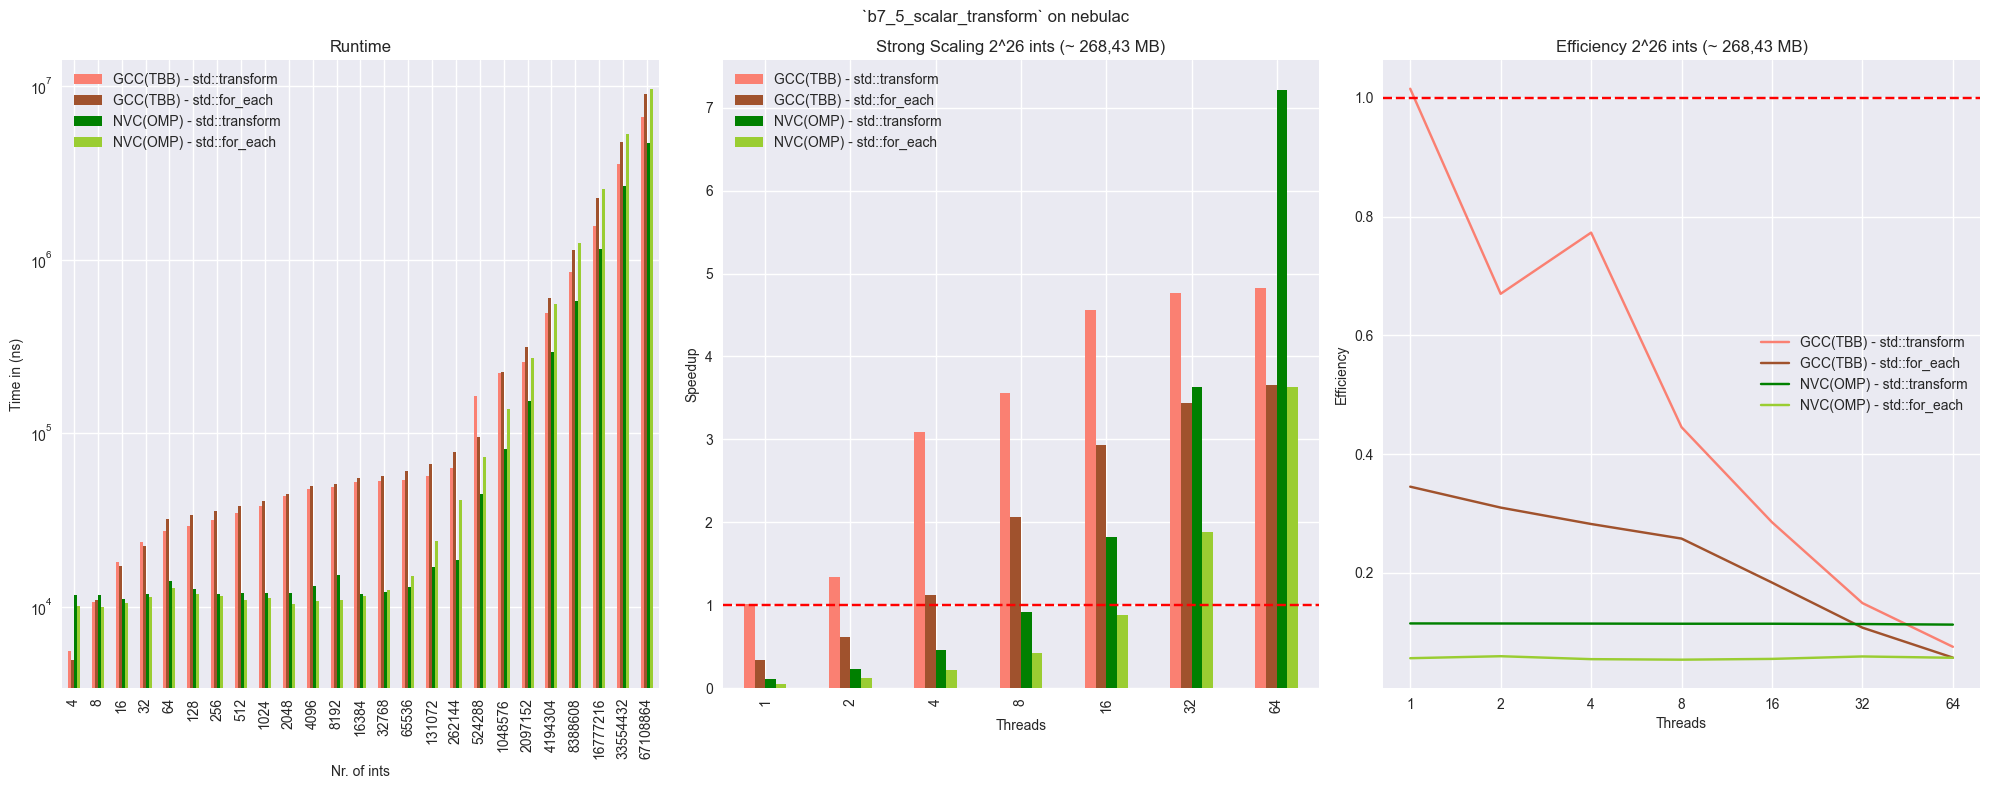

In [366]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_5_scalar_transform_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_5_scalar_transform_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b7_5_scalar_transform_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_5_scalar_transform` on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` {device_name}")

### Investigation GCC

In [392]:
b7_5_gcc_seq_nebula = extraction_pandas_frame_algo(root_dir + f'/GCC_TBB/DEFAULT/b7_5_scalar_transform_number_seq__Default.csv',COMP='GCC',include_bytes_per_second=True)

b7_5_gcc_seq_nebula = b7_5_gcc_seq_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_gcc_seq_nebula = b7_5_gcc_seq_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_gcc_seq_nebula['NEBULA-BYTES'] = b7_5_gcc_seq_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_gcc_seq_nebula

,NEBULA-TIME,NEBULA-BYTES
0,32924900.0,16.3059


In [391]:
b7_5_gcc_threaded_nebula = extraction_pandas_frame_algo_threaded(f'{root_dir}/GCC_TBB/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_gcc_threaded_nebula = b7_5_gcc_threaded_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_gcc_threaded_nebula = b7_5_gcc_threaded_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_gcc_threaded_nebula['NEBULA-BYTES'] = b7_5_gcc_threaded_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_gcc_threaded_nebula

,NEBULA-TIME,NEBULA-BYTES,threads
0,32431000.0,16.5542,1
1,24575600.0,21.8457,2
2,10649600.0,50.4125,4
3,9244360.0,58.0755,8
4,7217030.0,74.3894,16
5,6908050.0,77.7167,32


In [393]:
b7_5_gcc_threaded_hydra = extraction_pandas_frame_algo_threaded(f'/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/GCC_TBB/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_gcc_threaded_hydra = b7_5_gcc_threaded_hydra.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_gcc_threaded_hydra = b7_5_gcc_threaded_hydra.rename(columns={'real_time':'HYDRA-TIME','bytes_per_second':'HYDRA-BYTES'})

b7_5_gcc_threaded_hydra['HYDRA-BYTES'] = b7_5_gcc_threaded_hydra['HYDRA-BYTES'] / 1_000_000_000

b7_5_gcc_threaded_hydra

,HYDRA-TIME,HYDRA-BYTES,threads
0,46444500.0,11.5594,1
1,24214600.0,22.1714,2
2,13794600.0,38.9190,4
3,10674500.0,50.2949,8
4,8082180.0,66.4265,16
5,8423070.0,63.7382,32


Text(0.5, 1.0, 'GB/s GCC for b7_5_scalar_transform')

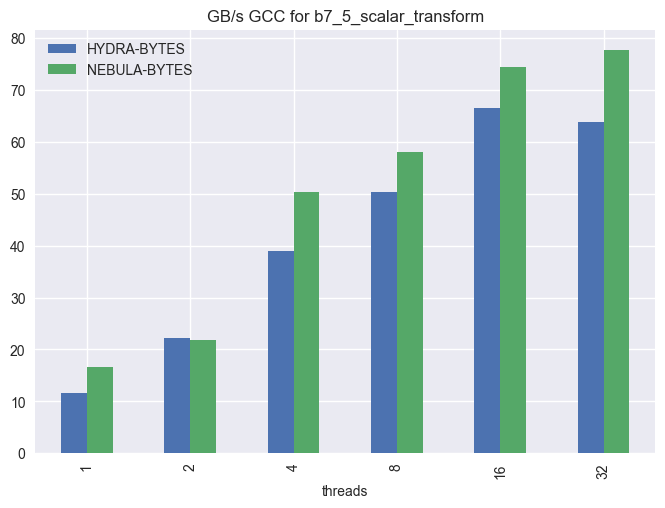

In [524]:
ax = pd.merge(b7_5_gcc_threaded_hydra,b7_5_gcc_threaded_nebula,on='threads').drop(columns=['HYDRA-TIME','NEBULA-TIME']).plot(kind='bar',x='threads')
ax.set_title('GB/s GCC for b7_5_scalar_transform')


In [459]:
def get_numa_node_for_cpu_nebula(cpu_id:int)-> int:
    # the lookup would be more efficient when we have CPU_ID -> NUMA NODE mapping but this is way to much work for this short thing
    numa_data : Dict[int,List[int]] = {
        0: [0, 8, 16, 24, 32, 40, 48, 56],
        1: [2, 10, 18, 26, 34, 42, 50, 58],
        2: [4,20,36,52,12,28,44,60],
        3: [6,22,38,54,14,30,46,62],
        4: [1,17,33,49,9,25,41,57],
        5: [3,19,35,51,11,27,43,59],
        6: [5,21,37,53,13,29,45,61],
        7: [7,23,39,55,15,31,47,63],
    }

    for key in numa_data.keys():
        if cpu_id in numa_data[key]:
            return key
    


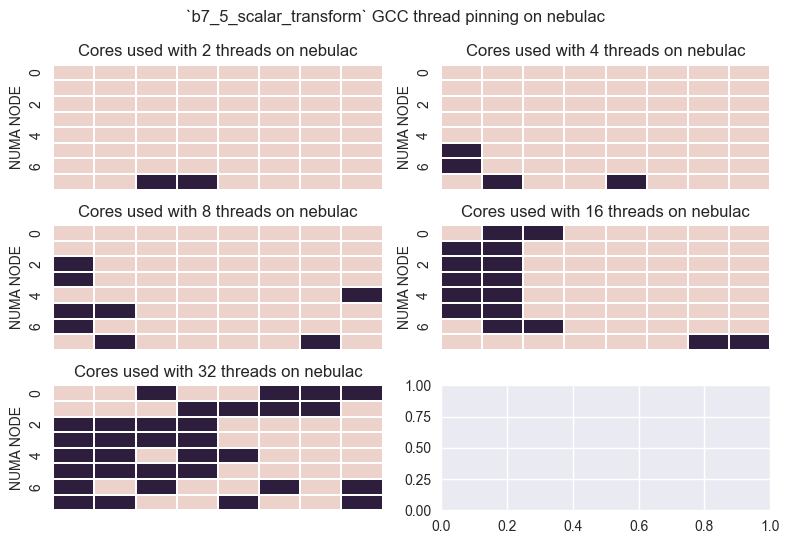

In [563]:
import seaborn as sns

# cpu dist
result: Dict[int,pd.DataFrame] = {}
for i in [2,4,8,16,32]:
    t2= pd.read_csv(f'{root_dir}/GCC_TBB/THREAD_PINNED_CYCLES/b7_5_T{i}.csv',header=None)
    t2 = t2.drop(columns=[2,3,4,5,6,7])

    t2 = t2.rename(columns={0:'CPU',1:'CYCLES'})

    nth_highest_val = t2['CYCLES'].nlargest(i).iloc[-1]

    t2['CYCLES'] = np.where(t2.CYCLES < nth_highest_val,0, 1)

    t2['CPU'] = t2['CPU'].map(lambda x: int(x.lstrip('CPU')))
    t2['NUMA_NODE'] = t2['CPU'].apply(lambda x: get_numa_node_for_cpu_nebula(x))
    
    lvl0 = t2.NUMA_NODE.values
    lvl1 = t2.CPU.values

    t2 = t2.drop(columns=['NUMA_NODE','CPU'])

    index = pd.MultiIndex.from_arrays([lvl0, lvl1], names=['NUMA NODE','CPU'])
    t2 = t2.set_index(index)

    result[i] = t2

fig, axs = plt.subplots(ncols=2, nrows=3)

positions = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
counter = 0
for i in [2,4,8,16,32]:
    pos = positions[counter]
    ax = axs[pos[0]][pos[1]]
    
    heatmap_df = result[i].reset_index().pivot(columns='CPU',index='NUMA NODE',values='CYCLES')

    heatmap_df = pd.DataFrame(justify(heatmap_df.values, invalid_val=np.nan, side='left', axis=1), 
                    columns=heatmap_df.columns,index=heatmap_df.index)

    heatmap_df = heatmap_df.dropna(axis='columns')
    heatmap_df = heatmap_df.fillna(0)

    ax = sns.heatmap(heatmap_df,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,ax=ax,cbar=False,linewidths=0.05)

    ax.set_title(f'Cores used with {i} threads on {device_name}')
    ax.get_xaxis().set_visible(False)
    counter = counter + 1


fig.suptitle(f"`b7_5_scalar_transform` GCC thread pinning on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` GCC thread pinning on {device_name}")

### Investigation NVC

In [528]:
b7_5_nvc_omp_nebula = extraction_pandas_frame_algo(root_dir + f'/NVHPC_Multicore/DEFAULT/b7_5_scalar_transform_number_seq__Default.csv',COMP='GCC',include_bytes_per_second=True)

b7_5_nvc_omp_nebula = b7_5_nvc_omp_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_nebula = b7_5_nvc_omp_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_nvc_omp_nebula['NEBULA-BYTES'] = b7_5_nvc_omp_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_nebula

,NEBULA-TIME,NEBULA-BYTES
0,64964600.0,8.26405


In [526]:
b7_5_nvc_omp_threaded_nebula = extraction_pandas_frame_algo_threaded(f'{root_dir}/NVHPC_Multicore/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_nvc_omp_threaded_nebula = b7_5_nvc_omp_threaded_nebula.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_threaded_nebula = b7_5_nvc_omp_threaded_nebula.rename(columns={'real_time':'NEBULA-TIME','bytes_per_second':'NEBULA-BYTES'})

b7_5_nvc_omp_threaded_nebula['NEBULA-BYTES'] = b7_5_nvc_omp_threaded_nebula['NEBULA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_threaded_nebula

,NEBULA-TIME,NEBULA-BYTES,threads
0,287101000.0,1.86997,1
1,143712000.0,3.73575,2
2,71961100.0,7.46057,4
3,36049400.0,14.89270,8
4,18026600.0,29.78210,16
5,9052710.0,59.30500,32


In [530]:
b7_5_nvc_omp_hydra = extraction_pandas_frame_algo('/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/NVHPC_Multicore/DEFAULT/b7_5_scalar_transform_number_seq__Default.csv',COMP='GCC',include_bytes_per_second=True)

b7_5_nvc_omp_hydra = b7_5_nvc_omp_hydra.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_hydra = b7_5_nvc_omp_hydra.rename(columns={'real_time':'HYDRA-TIME','bytes_per_second':'HYDRA-BYTES'})

b7_5_nvc_omp_hydra['HYDRA-BYTES'] = b7_5_nvc_omp_hydra['HYDRA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_hydra

,HYDRA-TIME,HYDRA-BYTES
0,69309300.0,7.74602


In [527]:
b7_5_nvc_omp_threaded_hydra = extraction_pandas_frame_algo_threaded(f'/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES/GCC_TBB/THREADS',
                                               f'b7_5_scalar_transform_number_par',
                                               [1,2,4,8,16,32],
                                               COMP='GCG',
                                               include_bytes=True
)

b7_5_nvc_omp_threaded_hydra = b7_5_nvc_omp_threaded_hydra.drop(columns=['cpu_time','time_unit','n','median','stddev','Compiler','name'])
b7_5_nvc_omp_threaded_hydra = b7_5_nvc_omp_threaded_hydra.rename(columns={'real_time':'HYDRA-TIME','bytes_per_second':'HYDRA-BYTES'})

b7_5_nvc_omp_threaded_hydra['HYDRA-BYTES'] = b7_5_nvc_omp_threaded_hydra['HYDRA-BYTES'] / 1_000_000_000

b7_5_nvc_omp_threaded_hydra

,HYDRA-TIME,HYDRA-BYTES,threads
0,46444500.0,11.5594,1
1,24214600.0,22.1714,2
2,13794600.0,38.9190,4
3,10674500.0,50.2949,8
4,8082180.0,66.4265,16
5,8423070.0,63.7382,32


Text(0.5, 1.0, 'GB/s NVC(OMP) for b7_5_scalar_transform')

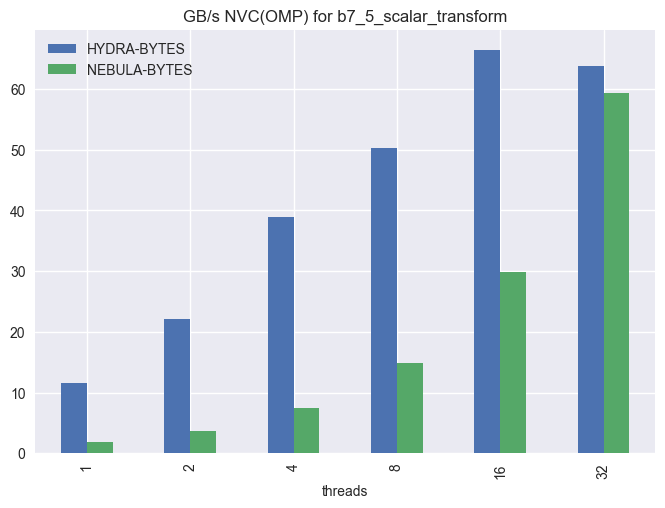

In [531]:
ax = pd.merge(b7_5_nvc_omp_threaded_hydra,b7_5_nvc_omp_threaded_nebula,on='threads').drop(columns=['HYDRA-TIME','NEBULA-TIME']).plot(kind='bar',x='threads')
ax.set_title('GB/s NVC(OMP) for b7_5_scalar_transform')


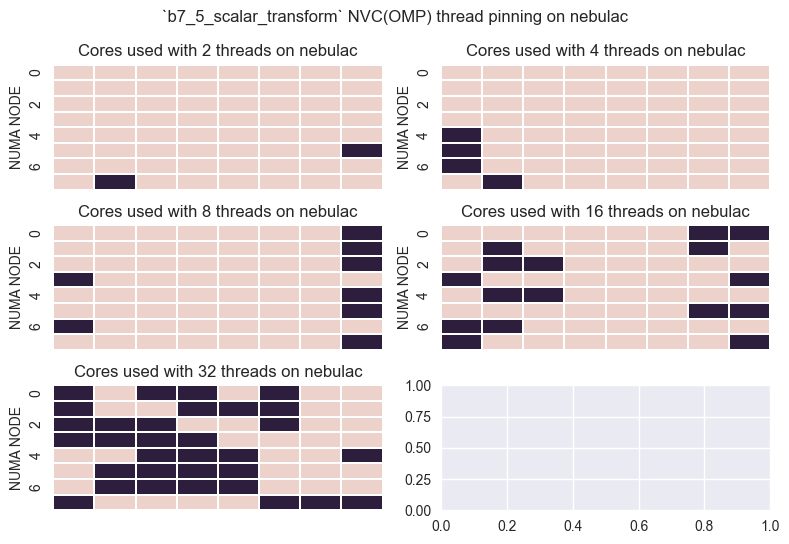

In [562]:
import seaborn as sns

# cpu dist
result: Dict[int,pd.DataFrame] = {}
for i in [2,4,8,16,32]:
    t2= pd.read_csv(f'{root_dir}/NVHPC_Multicore/THREAD_PINNED_CYCLES/b7_5_T{i}.csv',header=None)
    t2 = t2.drop(columns=[2,3,4,5,6,7])

    t2 = t2.rename(columns={0:'CPU',1:'CYCLES'})

    nth_highest_val = t2['CYCLES'].nlargest(i).iloc[-1]

    t2['CYCLES'] = np.where(t2.CYCLES < nth_highest_val,0, 1)

    t2['CPU'] = t2['CPU'].map(lambda x: int(x.lstrip('CPU')))
    t2['NUMA_NODE'] = t2['CPU'].apply(lambda x: get_numa_node_for_cpu_nebula(x))
    
    lvl0 = t2.NUMA_NODE.values
    lvl1 = t2.CPU.values

    t2 = t2.drop(columns=['NUMA_NODE','CPU'])

    index = pd.MultiIndex.from_arrays([lvl0, lvl1], names=['NUMA NODE','CPU'])
    t2 = t2.set_index(index)

    result[i] = t2

fig, axs = plt.subplots(ncols=2, nrows=3)

positions = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
counter = 0
for i in [2,4,8,16,32]:
    pos = positions[counter]
    ax = axs[pos[0]][pos[1]]
    
    heatmap_df = result[i].reset_index().pivot(columns='CPU',index='NUMA NODE',values='CYCLES')

    heatmap_df = pd.DataFrame(justify(heatmap_df.values, invalid_val=np.nan, side='left', axis=1), 
                    columns=heatmap_df.columns,index=heatmap_df.index)

    heatmap_df = heatmap_df.dropna(axis='columns')
    heatmap_df = heatmap_df.fillna(0)

    ax = sns.heatmap(heatmap_df,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,ax=ax,cbar=False,linewidths=0.05)
    ax.set_title(f'Cores used with {i} threads on {device_name}')
    ax.get_xaxis().set_visible(False)
    counter = counter + 1

fig.suptitle(f"`b7_5_scalar_transform` NVC(OMP) thread pinning on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` NVC(OMP) thread pinning on {device_name}")

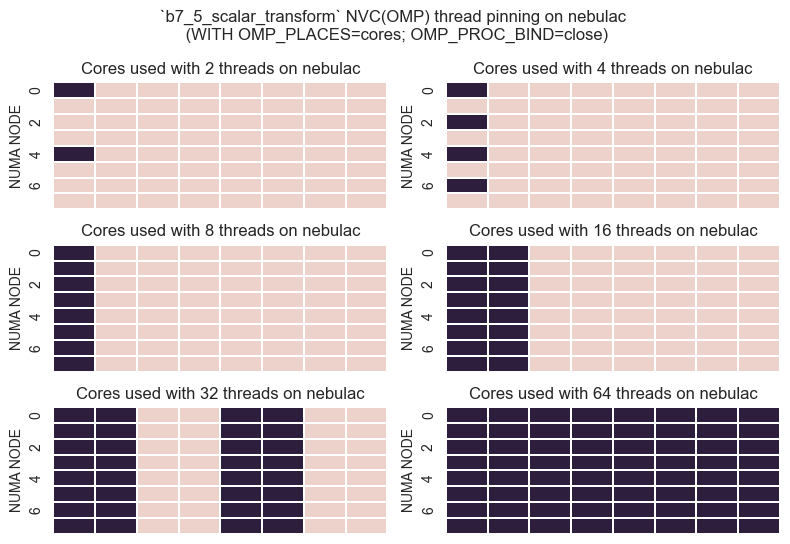

In [559]:
import seaborn as sns

# cpu dist
result: Dict[int,pd.DataFrame] = {}
for i in [2,4,8,16,32,64]:
    t2= pd.read_csv(f'{root_dir}/NVHPC_Multicore/THREAD_PINNED_CYCLES/b7_5_EXTRA_T{i}.csv',header=None)
    t2 = t2.drop(columns=[2,3,4,5,6,7])

    t2 = t2.rename(columns={0:'CPU',1:'CYCLES'})

    nth_highest_val = t2['CYCLES'].nlargest(i).iloc[-1]

    t2['CYCLES'] = np.where(t2.CYCLES < nth_highest_val,0, 1)

    t2['CPU'] = t2['CPU'].map(lambda x: int(x.lstrip('CPU')))
    t2['NUMA_NODE'] = t2['CPU'].apply(lambda x: get_numa_node_for_cpu_nebula(x))
    
    lvl0 = t2.NUMA_NODE.values
    lvl1 = t2.CPU.values

    t2 = t2.drop(columns=['NUMA_NODE','CPU'])

    index = pd.MultiIndex.from_arrays([lvl0, lvl1], names=['NUMA NODE','CPU'])
    t2 = t2.set_index(index)

    result[i] = t2

fig, axs = plt.subplots(ncols=2, nrows=3)

positions = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
counter = 0
for i in [2,4,8,16,32,64]:
    pos = positions[counter]
    ax = axs[pos[0]][pos[1]]
    
    heatmap_df = result[i].reset_index().pivot(columns='CPU',index='NUMA NODE',values='CYCLES')

    heatmap_df = pd.DataFrame(justify(heatmap_df.values, invalid_val=np.nan, side='left', axis=1), 
                    columns=heatmap_df.columns,index=heatmap_df.index)

    heatmap_df = heatmap_df.dropna(axis='columns')
    heatmap_df = heatmap_df.fillna(0)

    ax = sns.heatmap(heatmap_df,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1,ax=ax,cbar=False,linewidths=0.05)
    ax.set_title(f'Cores used with {i} threads on {device_name}')
    ax.get_xaxis().set_visible(False)
    counter = counter + 1

fig.suptitle(f"`b7_5_scalar_transform` NVC(OMP) thread pinning on {device_name} \n (WITH OMP_PLACES=cores; OMP_PROC_BIND=close)")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` NVC(OMP) (WITH OMP_PLACES=cores; OMP_PROC_BIND=close) thread pinning on {device_name}")

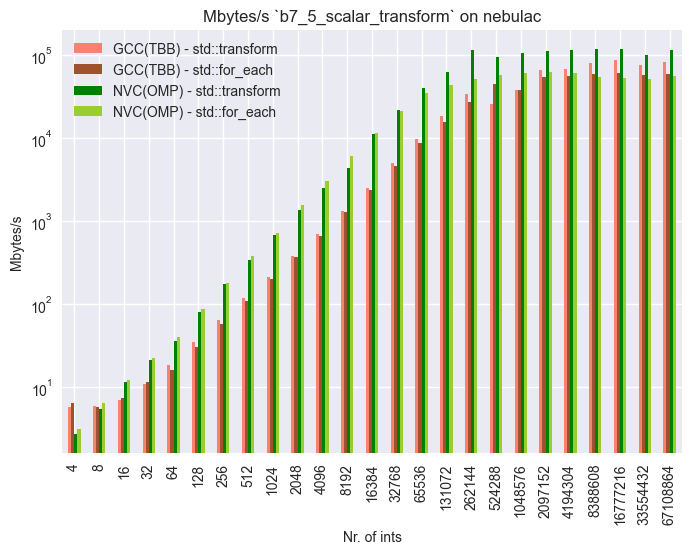

In [367]:

# mbytes graph

b7_5_scalar_transform_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_5_scalar_transform` on {device_name}')


plot(f'`b7_5_scalar_transform` Mbytes_s on {device_name}')

## `b7_6` - Serial vs direct call

In [368]:
benchmark_names = [
    ("b7_6_transform_reduce",'std::transform_reduce'),
    ("b7_6_serial_transform_reduce",'serial')
]

strong_scale_base = 'b7_6_transform_reduce'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [369]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_6_transform_reduce_vs_serial_time_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_time_merged = pd.merge(b7_6_transform_reduce_vs_serial_time_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_time_merged

,GCC(TBB) - std::transform_reduce,n,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,3593.01,4,7.222830e+03,20548.1,35165.0
1,8566.81,8,1.676770e+04,20999.5,34805.3
2,15404.50,16,3.817470e+04,22082.5,34893.9
3,21473.60,32,4.823910e+04,23838.6,38893.6
4,26736.20,64,5.602220e+04,22213.2,42200.2
5,25202.00,128,6.149680e+04,23374.8,47407.8
6,27385.30,256,6.421880e+04,23836.4,43404.7
7,29435.30,512,6.917970e+04,23743.0,46898.7
8,32367.20,1024,7.689750e+04,23133.3,53564.3
9,36136.50,2048,8.627010e+04,23144.2,50681.5


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [370]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_6_transform_reduce_vs_serial_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_strong_scaling_merged = pd.merge(b7_6_transform_reduce_vs_serial_strong_scaling_merged,data[i], on='threads')


b7_6_transform_reduce_vs_serial_strong_scaling_merged

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.997051,0.487294,0.658931,0.194196
1,2,1.885121,0.651194,1.326386,0.348409
2,4,3.065848,0.838129,2.622642,0.542556
3,8,4.138626,0.611728,5.194307,0.620306
4,16,6.281560,0.615429,10.050097,0.556548
5,32,7.102774,0.694649,17.323516,0.564573
6,64,7.609602,0.686321,17.882367,0.577684


In [371]:
## efficiency graph

b7_6_transform_reduce_vs_serial_efficiency = b7_6_transform_reduce_vs_serial_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] = b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] / b7_6_transform_reduce_vs_serial_efficiency['threads']

b7_6_transform_reduce_vs_serial_efficiency

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.997051,0.487294,0.658931,0.194196
1,2,0.942561,0.325597,0.663193,0.174204
2,4,0.766462,0.209532,0.655660,0.135639
3,8,0.517328,0.076466,0.649288,0.077538
4,16,0.392598,0.038464,0.628131,0.034784
5,32,0.221962,0.021708,0.541360,0.017643
6,64,0.118900,0.010724,0.279412,0.009026


### Mbytes/s   

In [372]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_6_transform_reduce_vs_serial_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_bytes_merged = pd.merge(b7_6_transform_reduce_vs_serial_bytes_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_bytes_merged

,n,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,4,8.90617,13.2912,1.55732,2.72999
1,8,7.47069,11.4506,3.04769,5.51641
2,16,8.30928,10.0590,5.79643,11.00480
3,32,11.92160,15.9207,10.73890,19.74620
4,64,19.15010,27.4177,23.04930,36.39800
5,128,40.63170,49.9538,43.80780,64.79940
6,256,74.78470,95.6729,85.91900,141.55100
7,512,139.15300,177.6240,172.51400,262.01200
8,1024,253.09600,319.5940,354.12100,458.81300
9,2048,453.39200,569.7450,707.91100,969.82100


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_2415/182734503.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


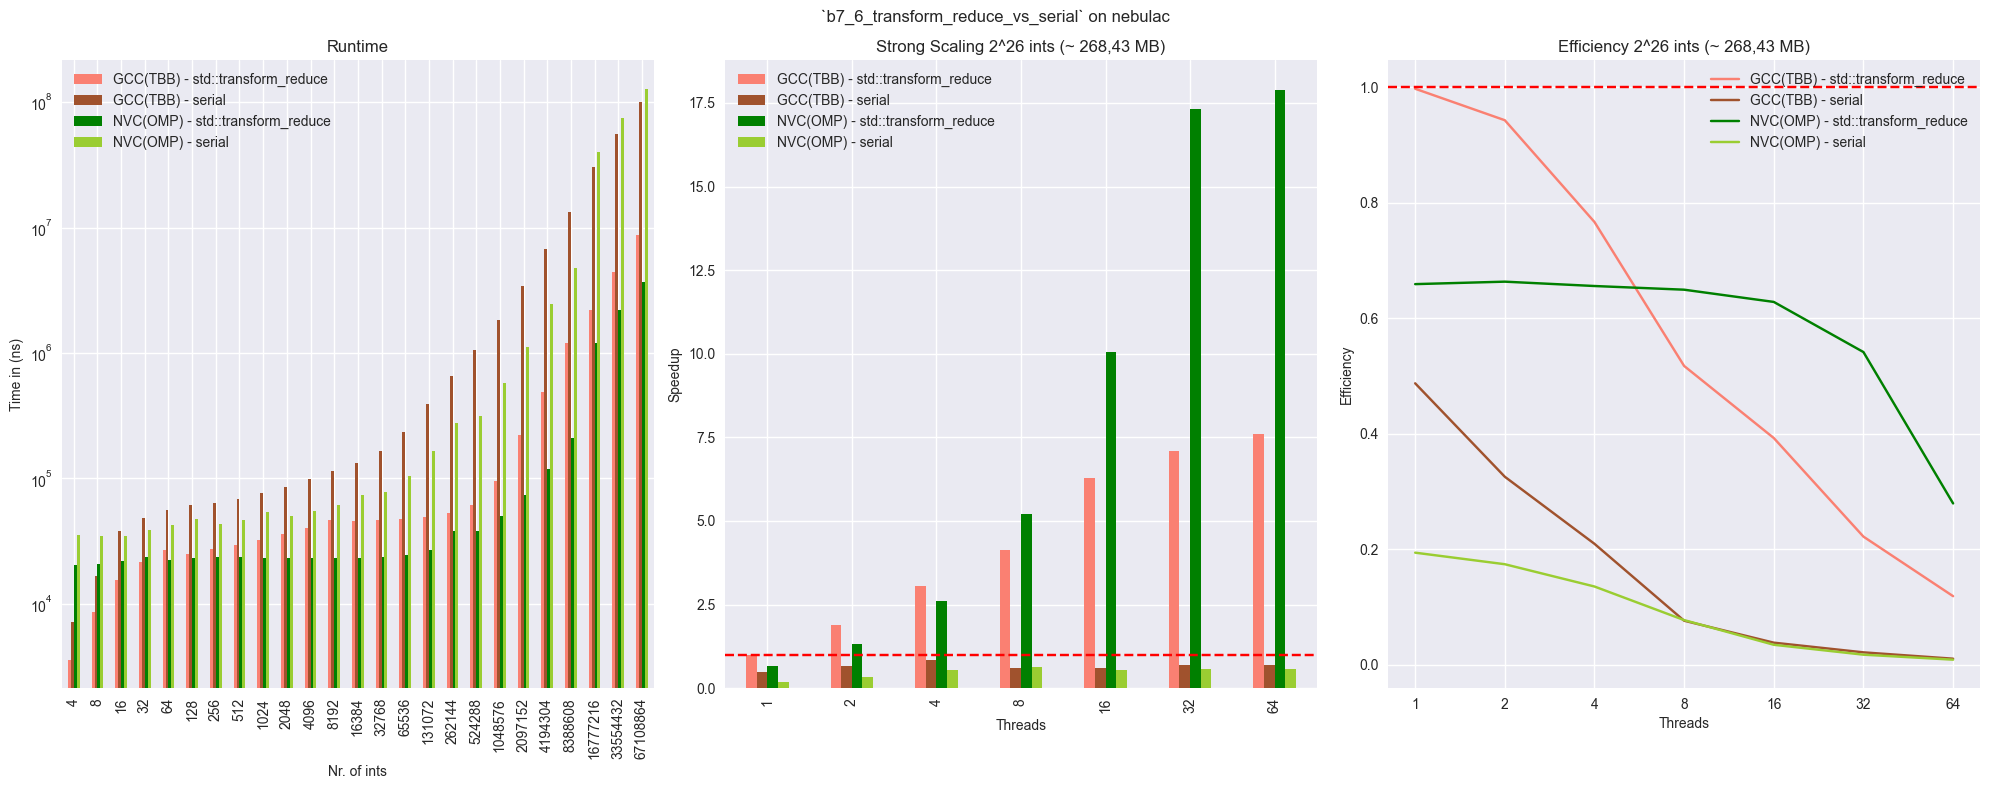

In [373]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_6_transform_reduce_vs_serial_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_6_transform_reduce_vs_serial_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_6_transform_reduce_vs_serial_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_6_transform_reduce_vs_serial` on {device_name}")

fig.tight_layout()

plot(f"`b7_6_transform_reduce_vs_serial` {device_name}")

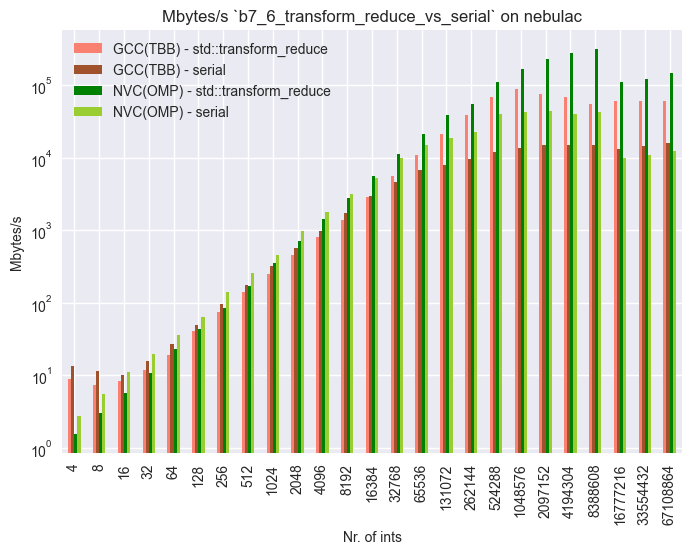

In [374]:
# mbytes graph

b7_6_transform_reduce_vs_serial_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_6_transform_reduce_vs_serial` on {device_name}')


plot(f'`b7_6_transform_reduce_vs_serial` Mbytes_s on {device_name}')

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime

In [375]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b7_1_copy',b7_1_time_merged, [' - std::copy', ' - std::foreach']),
    
    ('b7_2_all_of_all_true',b7_2_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_first_false',b7_2_first_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_last_false',b7_2_last_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_auto_false',b7_2_auto_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),


    ('b7_3_count_if_all_hit',b7_3_all_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_half_hit',b7_3_half_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_orders_struct',b7_3_orders_struct_time_merged, [' - std::count_if', ' - std::transform_reduce']),

    
    ('b7_4_stencil_transform',b7_4_stencil_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_5_scalar_transform',b7_5_scalar_transform_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_6_transform_reduce',b7_6_transform_reduce_vs_serial_time_merged, [' - std::transform_reduce', ' - serial']),
]


for root_display_name, data_source, suffixes in data_fields:

    for suffix in suffixes:
        entry_dict = {
            'name': [root_display_name + suffix],
        }

        vals = []

        # getting the data from the source for each compiler
        for comp in compilers:
            current_val = int(data_source.iloc[-1][comp + suffix])
            entry_dict[comp] = [current_val]

            vals.append(current_val)

        entry_dict['PP'] = calc_pp(vals)

        other_df = pd.DataFrame.from_dict(entry_dict)
        pp_df = pd.concat([pp_df,other_df],ignore_index=True)



pp_df['Percentage'] = pp_df['PP']

pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')


pp_df_styled = pp_df.style.format({'Percentage': "{:.2%}"})
pp_df_styled

,name,GCC(TBB),NVC(OMP),PP,Percentage,INTERPRET
0,b7_1_copy - std::copy,7120290,4846030,0.809945,80.99%,BAD
1,b7_1_copy - std::foreach,9732500,17002500,0.728072,72.81%,BAD
2,b7_2_all_of_all_true - std::all_of,3027090,10422900,0.450125,45.01%,BAD
3,b7_2_all_of_all_true - std::transform_reduce,2971620,1941560,0.790348,79.03%,BAD
4,b7_2_all_of_first_false - std::all_of,26660,74085,0.529257,52.93%,BAD
5,b7_2_all_of_first_false - std::transform_reduce,2979110,2192990,0.848008,84.80%,BAD
6,b7_2_all_of_last_false - std::all_of,2558250,11045600,0.376107,37.61%,BAD
7,b7_2_all_of_last_false - std::transform_reduce,3105700,1794350,0.732380,73.24%,BAD
8,b7_2_all_of_auto_false - std::all_of,24962,52760,0.642341,64.23%,BAD
9,b7_2_all_of_auto_false - std::transform_reduce,226010,25849,0.205266,20.53%,BAD


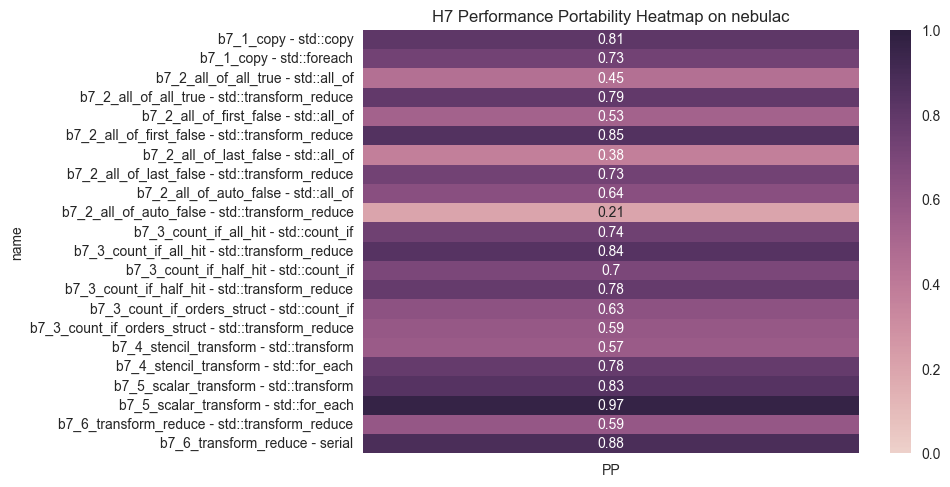

In [376]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','Percentage','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H7 Performance Portability Heatmap on {device_name}')

plot(f'H7 Performance Portability Heatmap on {device_name}')

## Findings for H7

### XXX

### General


### GPU Findings


### Hypothesis Findings


